# <font color="red">VQ1 Codebook Hierarchical Clustering and Feature Spectra<font/>
1. Load "all" vqindhist of a given with batch output_layer = f'vqindhist{vq_idx}' (vq_idx=1) from batch X (batch_size, 2048)
2. Find a representatieve signature per marker - Group by marker ID and average vqindhist vectors (num_markers, 2048)
3. Find codewords that appear together - Calculate codewords correlaion matrix (between columns) (2048, 2048)
4. Hierarchical clustering on codewords correlation matrix. Decide on lables to include for codeword clustering (e.g., WT vs. stress, all markers).
5. Infer number of clusters (w/ Lena)
6. Sort vqind indecies accordingly
7. Decide on data (e.g., WT vs. stress, all markers) to be plotted as groups 
8. Generate (sorted) features spectra per group/label - which is re-sroting vqindhist indecies. and stacking histograms from the same group. 
8. Plotting feature spectras - a histogram for each group  

In [2]:
import os
import sys

import scipy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import warnings

sys.path.insert(1, os.getenv("MOMAPS_HOME"))

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport
warnings.filterwarnings('ignore')


Modules to reload:
all-except-skipped

Modules to skip:



## Load vqindhist

In [20]:
# ind, labels = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/ind_b9_vqindhist1.npy"),\
#                 np.load("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/vqindhist/labels_b9_1.npy")
 
batch_number = 6#8#3#4#5#6 #9
set_name = "all"#"trainset"#"testset" #"all"
ind, labels = np.load(f"/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/vqindhist1/neurons/vqindhist1/batch{batch_number}_16bit_no_downsample/vqindhist1_{set_name}.npy"),\
    np.load(f"/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/vqindhist1/neurons/vqindhist1/batch{batch_number}_16bit_no_downsample/vqindhist1_labels_{set_name}.npy")

 
ind = ind.reshape(ind.shape[0], -1)
print(f"batch number: {batch_number}, set: {set_name}")
print(ind.shape, labels.shape)
print(np.unique(labels).shape)

batch number: 6, set: all
(319837, 2048) (319837,)
(448,)


## Save the histograms in a dataframe (hist_df) and add the label

In [12]:
hist_df = pd.DataFrame(ind)
hist_df['label'] = labels
hist_df

0    1    2    3    4    5    6    7    8    9  ...  2039  2040  \
0       0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
2       0.0  0.0  1.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   2.0   
3       0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   4.0   
4       0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   1.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
214620  0.0  0.0  0.0  0.0  8.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
214621  1.0  0.0  0.0  1.0  3.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
214622  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   1.0   
214623  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   4.0   
214624  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.0   3.0   

        2041  2042  2043  2044  2045  2046  2047  \
0        1.0   1.0   0.0   0.0   0.0   0.0   0.0   
1        1.0   0.0   0.0   0.0   0.0   0.0   0.0   
2        2.0   0.0   0.0   0.0   0.0   0.0   0.0   
3        1.0   0.0   0.0   0.0   0.0   0.0   0.0   
4        1.0   0.0   0.0   0.0   0.0   0.0   0.0   
...      ...   ...   ...   ...   ...   ...   ...   
214620   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
214621   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
214622   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
214623   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
214624   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                                    label  
0       batch7_16bit_no_downsample/FUSHomozygous/Untre...  
1       batch7_16bit_no_downsample/FUSHomozygous/Untre...  
2       batch7_16bit_no_downsample/FUSHomozygous/Untre...  
3       batch7_16bit_no_downsample/FUSHomozygous/Untre...  
4       batch7_16bit_no_downsample/FUSHomozygous/Untre...  
...                                                   ...  
214620  batch7_16bit_no_downsample/FUSRevertant/Untrea...  
214621  batch7_16bit_no_downsample/FUSRevertant/Untrea...  
214622  batch7_16bit_no_downsample/FUSRevertant/Untrea...  
214623  batch7_16bit_no_downsample/FUSRevertant/Untrea...  
214624  batch7_16bit_no_downsample/FUSRevertant/Untrea...  

[214625 rows x 2049 columns]

In [ ]:
labels[0][0].split('_')

['LAMP1', 'FUSRevertant', 'Untreated']

In [22]:
import src.common.lib.synthetic_multiplexing as synthetic_multiplexing

# labels_df = pd.DataFrame([(s.split('_')[0], '_'.join(s.split('_')[-3 + int(not False):])) for s in labels.reshape(-1,)], columns=['Marker', 'Pheno'])
labels_df = pd.DataFrame([(s.split('/')[-1], '_'.join(s.split('/')[-4 :-1- int(False)])) for s in labels.reshape(-1,)], columns=['Marker', 'Pheno'])

embeddings_series = pd.DataFrame({"Embeddings": [*ind]})
df = pd.merge(labels_df, embeddings_series, left_index=True, right_index=True)
df
# synthetic_multiplexing.__embeddings_to_df(ind, labels, dataset_conf)

Marker                        Pheno  \
0       G3BP1  FUSRevertant_Untreated_rep2   
1       G3BP1  FUSRevertant_Untreated_rep2   
2       G3BP1  FUSRevertant_Untreated_rep2   
3       G3BP1  FUSRevertant_Untreated_rep2   
4       G3BP1  FUSRevertant_Untreated_rep2   
...       ...                          ...   
319832  TDP43               WT_stress_rep1   
319833  TDP43               WT_stress_rep1   
319834  TDP43               WT_stress_rep1   
319835  TDP43               WT_stress_rep1   
319836  TDP43               WT_stress_rep1   

                                               Embeddings  
0       [0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, ...  
1       [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
2       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4       [0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                   ...  
319832  [0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
319833  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
319834  [0.0, 0.0, 3.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, ...  
319835  [0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
319836  [0.0, 1.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, ...  

[319837 rows x 3 columns]

In [23]:
lines_to_include = ['WT_Untreated_rep1','WT_stress_rep1']#, 'TDP43', 'TBK1', 'FUSHomozygous', 'FUSHeterozygous', 'FUSRevertant', 'OPTN', 'SCNA']
df = df[df["Pheno"].str.contains("|".join(lines_to_include))]
print(df.shape)

(38404, 3)


In [25]:
df.Pheno.value_counts()

Pheno
WT_stress_rep1       19487
WT_Untreated_rep1    18917
Name: count, dtype: int64

In [16]:
# # Exclude markers
# markers_to_exclude = ['FUS']
# # df = df[~df["Marker"].str.contains("|".join(markers_to_exclude))]#['Marker'].value_counts()
# df = df[~df["Marker"].str.contains("|".join(markers_to_exclude))]
# print(df.shape)

(206329, 3)


In [27]:
sm_embeddings, sm_label_data, sm_unique_groups = synthetic_multiplexing.__get_multiplexed_embeddings(df, random_state=1)
sm_embeddings.shape

(1012, 51200)

In [28]:
from umap import UMAP

reducer = UMAP(n_components=2,random_state=1)
sm_emb_reduced = reducer.fit_transform(sm_embeddings)
print(sm_emb_reduced.shape)

(1012, 2)


[0/2] WT_Untreated_rep1
[1/2] WT_stress_rep1


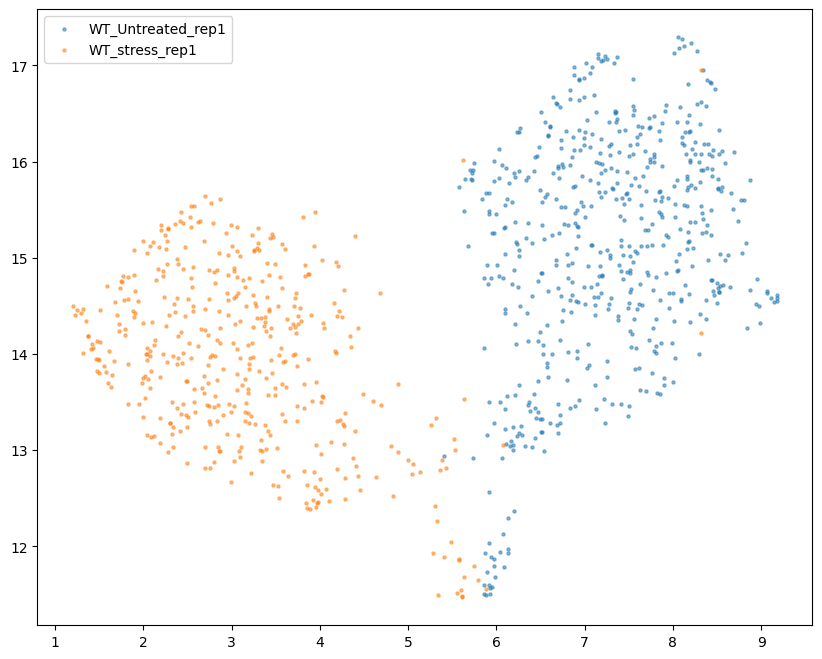

In [29]:
#b6 stress/Untreated rep1
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/8] FUSHeterozygous_Untreated
[1/8] FUSHomozygous_Untreated
[2/8] FUSRevertant_Untreated
[3/8] OPTN_Untreated
[4/8] TBK1_Untreated
[5/8] TDP43_Untreated
[6/8] WT_Untreated
[7/8] WT_stress


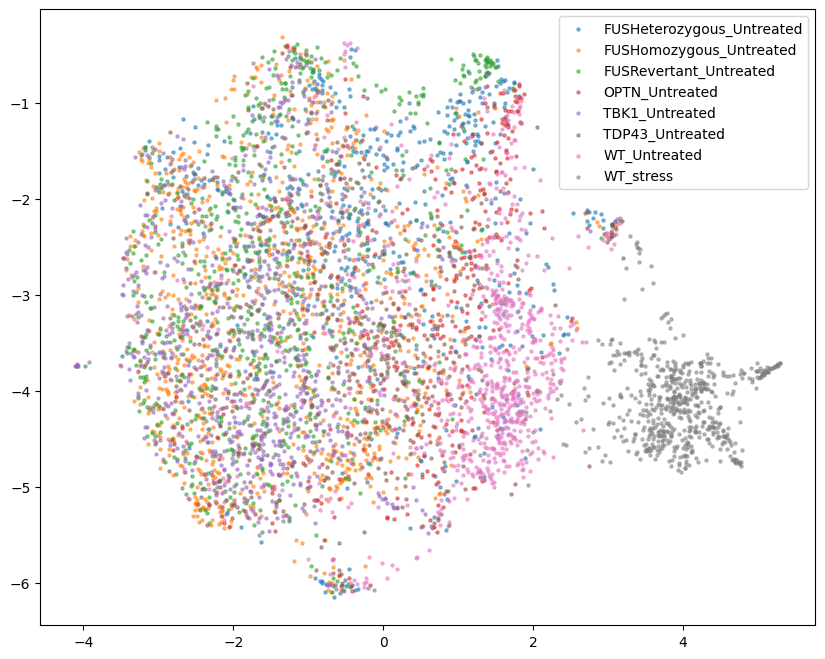

In [10]:
#b8 trainset without FUS as a marker
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


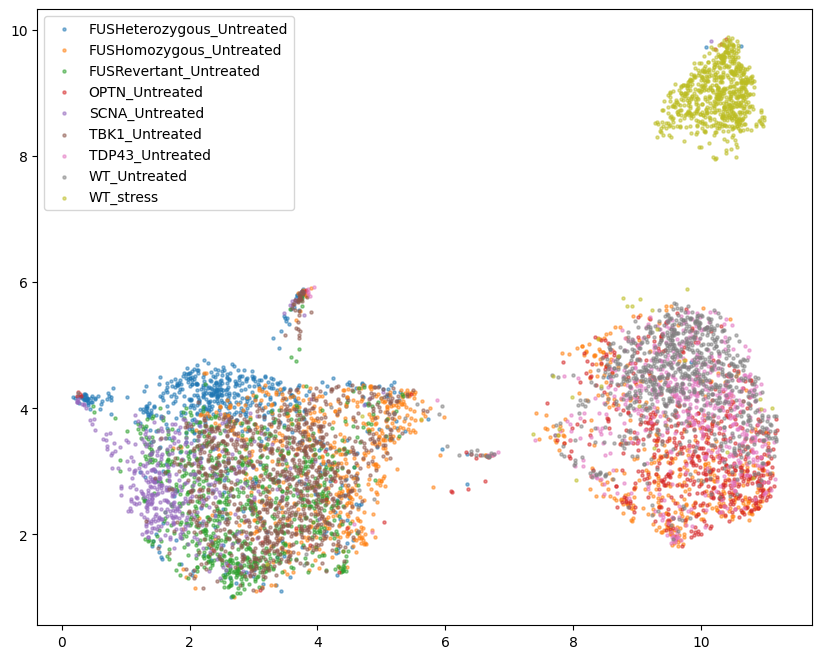

In [19]:
#b7 trainset without FUS as a marker with SCNA line
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/8] FUSHeterozygous_Untreated
[1/8] FUSHomozygous_Untreated
[2/8] FUSRevertant_Untreated
[3/8] OPTN_Untreated
[4/8] TBK1_Untreated
[5/8] TDP43_Untreated
[6/8] WT_Untreated
[7/8] WT_stress


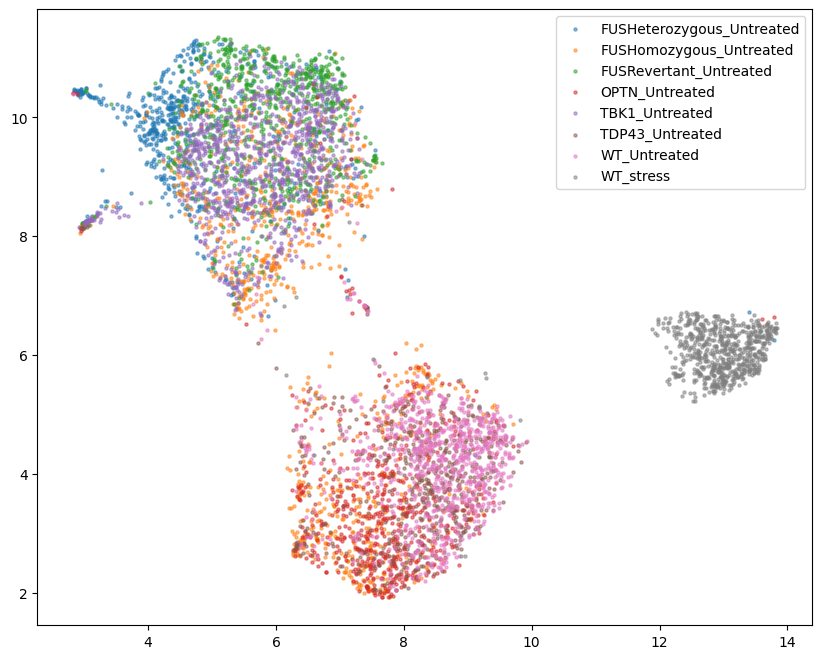

In [13]:
#b7 trainset without FUS as a marker
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


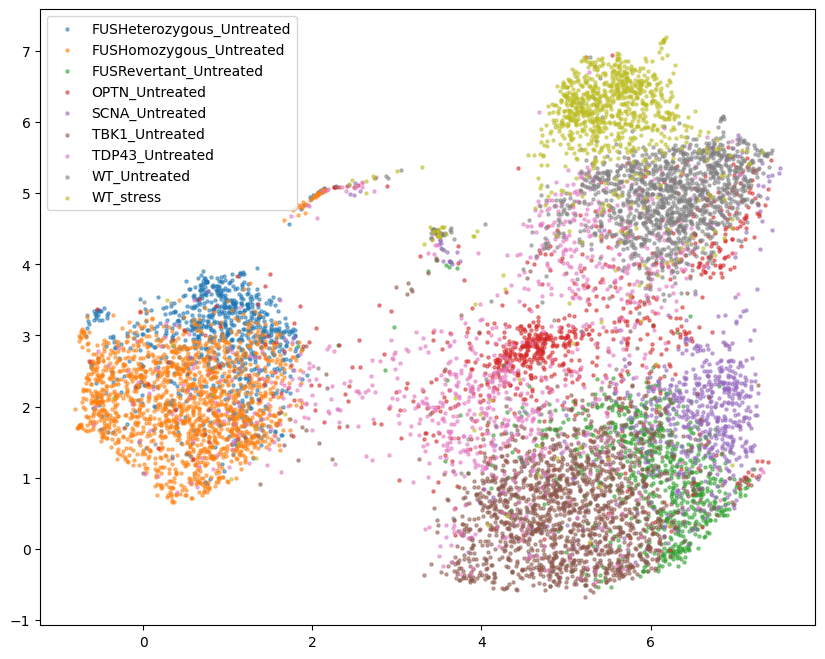

In [16]:
#b9
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


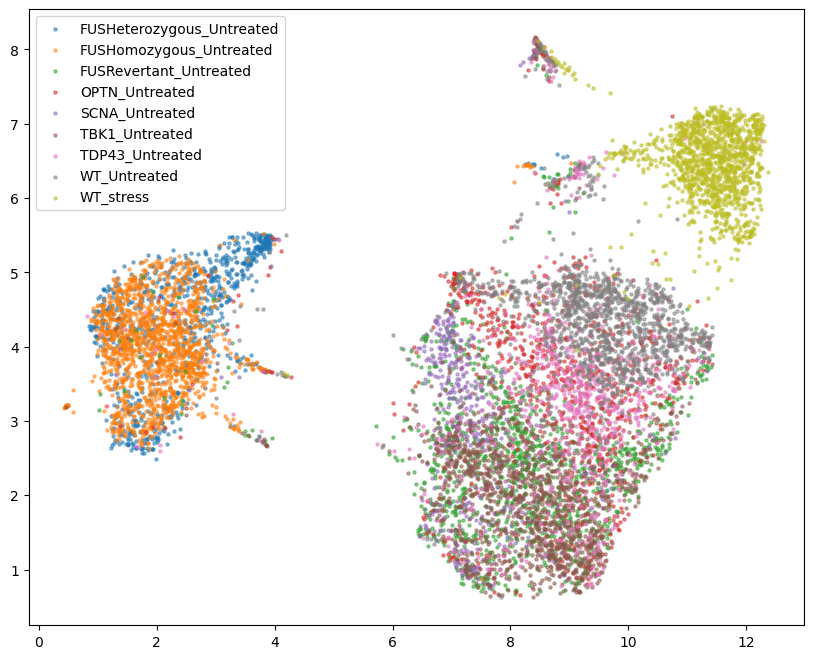

In [22]:
#b6
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


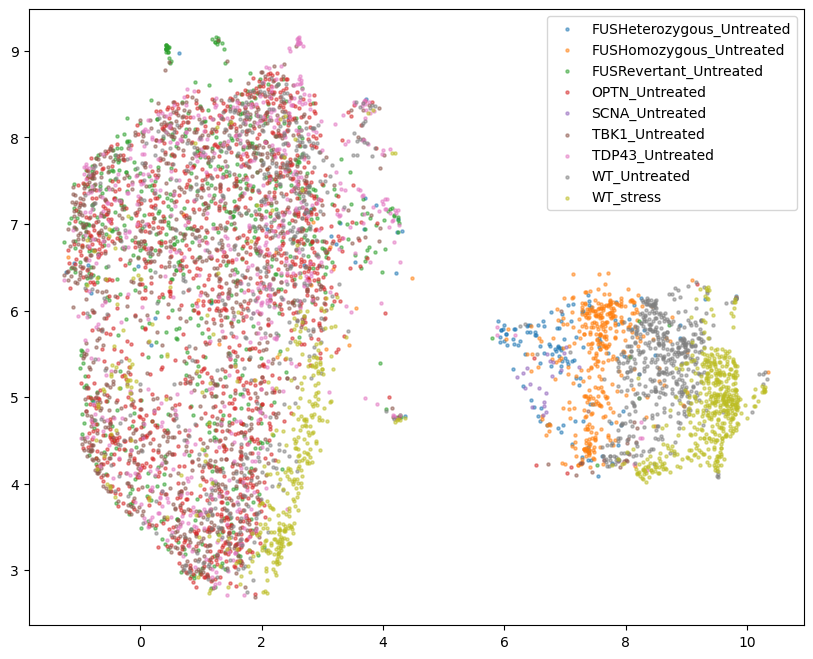

In [28]:
#b5
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


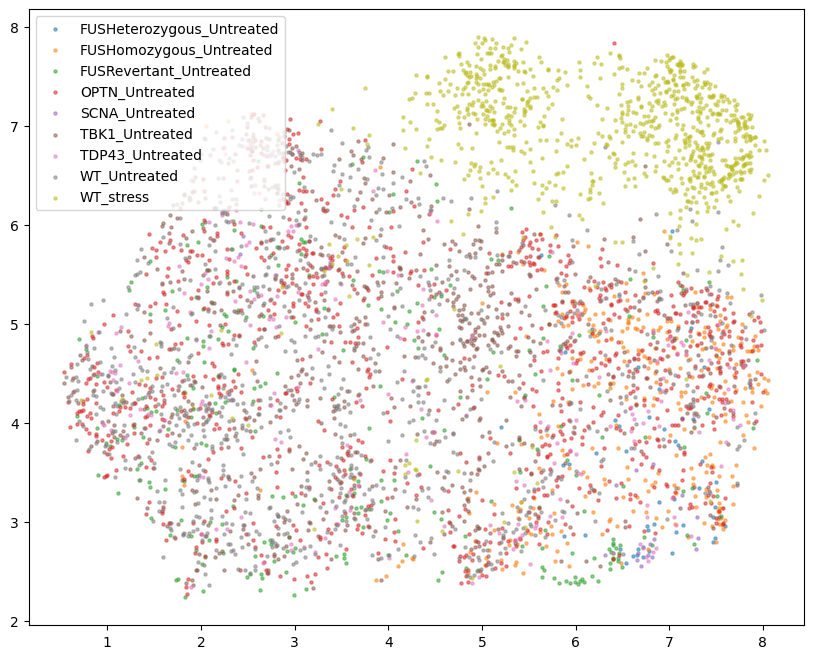

In [34]:
#b4
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


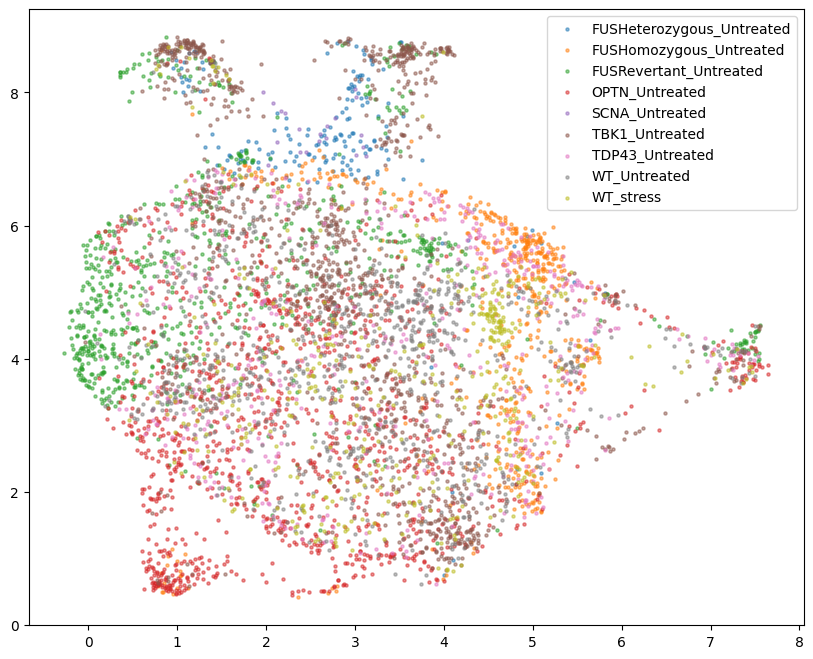

In [40]:
#b3
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


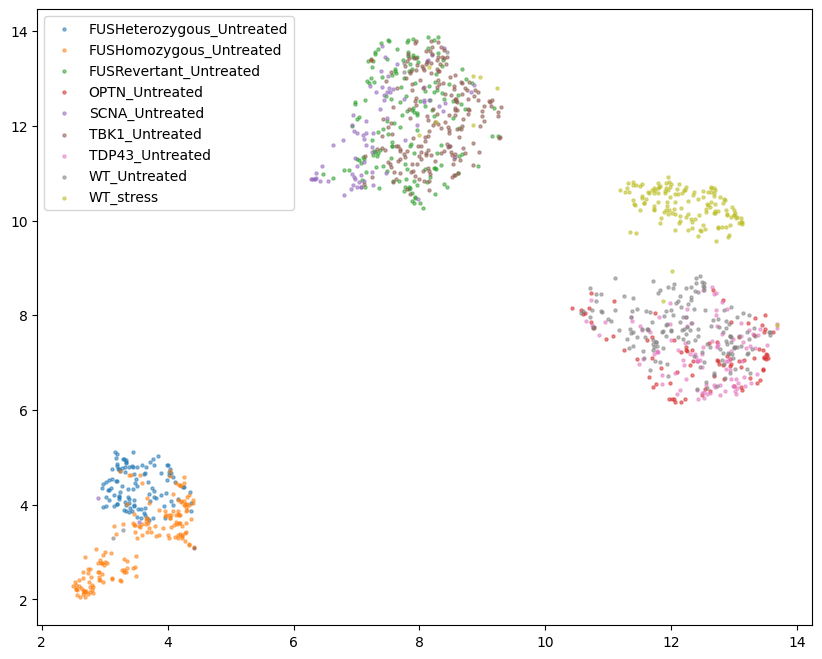

In [49]:
#b7 test
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


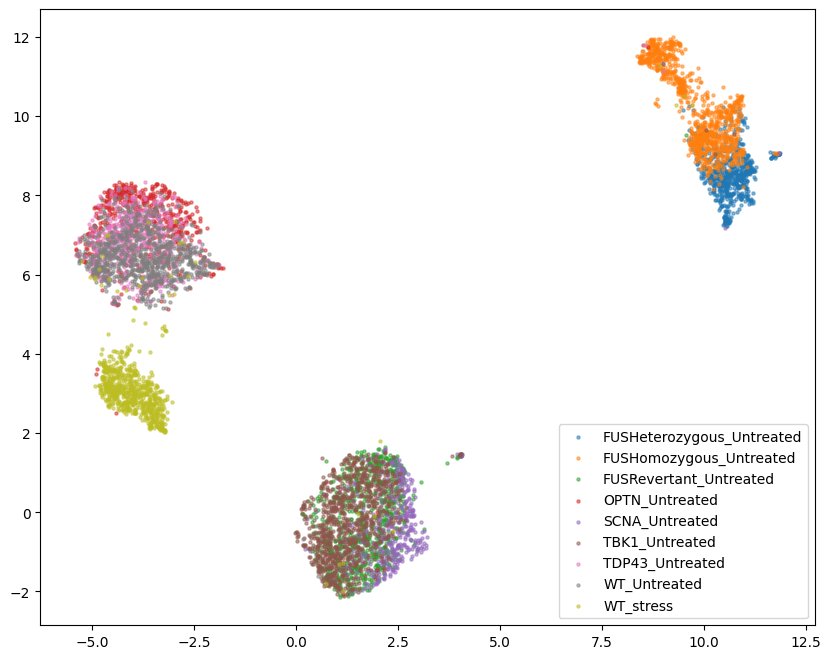

In [56]:
#b7 train
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/7] FUSHeterozygous_Untreated
[1/7] FUSHomozygous_Untreated
[2/7] FUSRevertant_Untreated
[3/7] TBK1_Untreated
[4/7] TDP43_Untreated
[5/7] WT_Untreated
[6/7] WT_stress


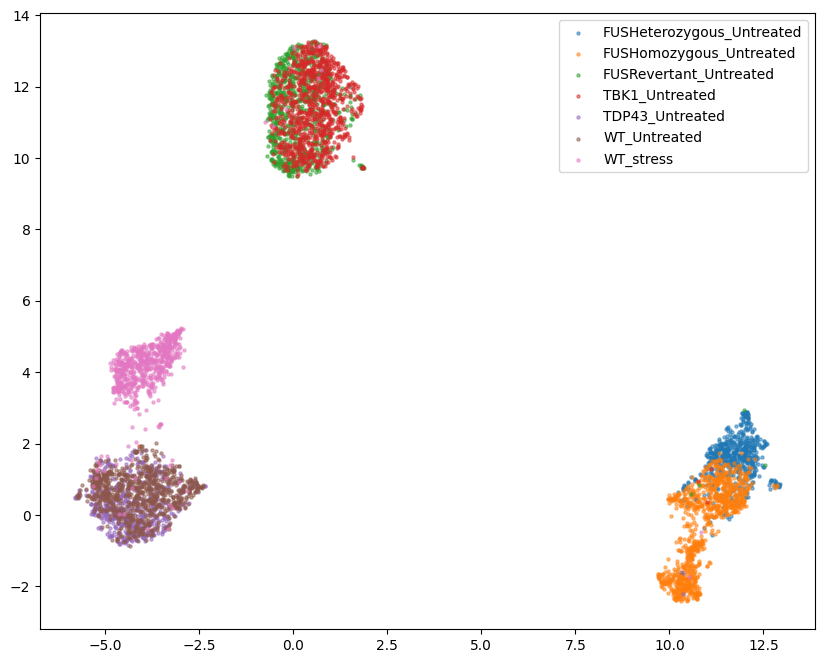

In [65]:
#b7 train (only ALS lines)
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

[0/7] FUSHeterozygous_Untreated
[1/7] FUSHomozygous_Untreated
[2/7] FUSRevertant_Untreated
[3/7] TBK1_Untreated
[4/7] TDP43_Untreated
[5/7] WT_Untreated
[6/7] WT_stress


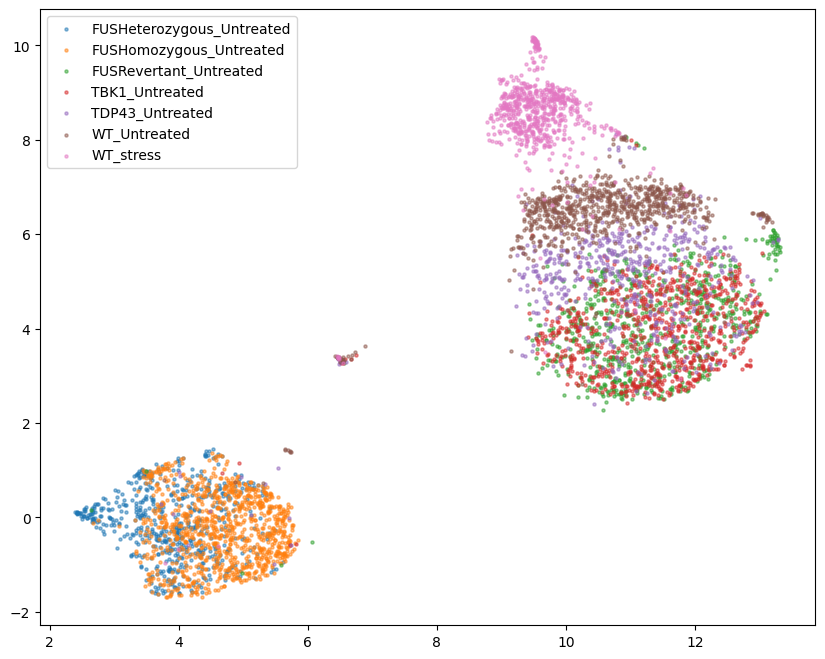

In [72]:
#b8 train (only ALS lines)
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

Sorted

2048

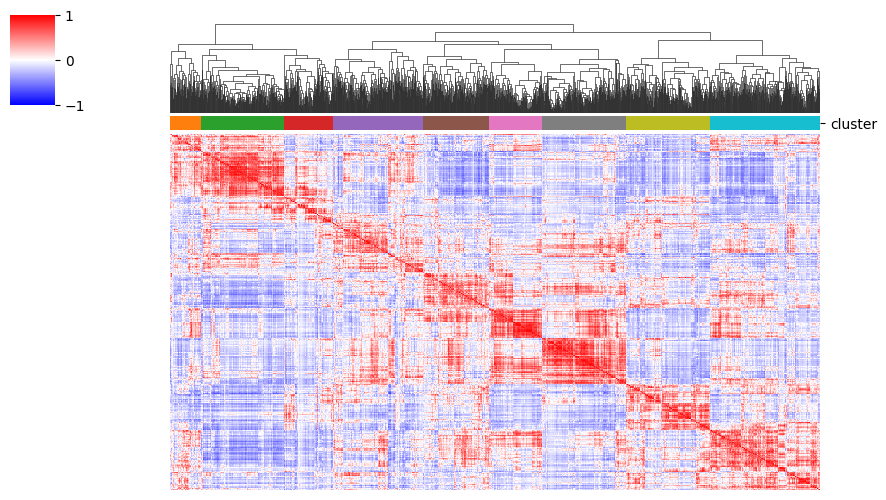

In [97]:
colormap_name = "viridis"
kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,5), xticklabels=False, yticklabels=False, col_colors=corr_with_clusters.cluster, **kws)
clustermap.ax_row_dendrogram.set_visible(False)

# get the indices order from the dendrogram 
hierarchical_order = clustermap.dendrogram_col.reordered_ind
len(hierarchical_order)

In [101]:
import src.common.lib.synthetic_multiplexing as synthetic_multiplexing

labels_df = pd.DataFrame([(s.split('_')[0], '_'.join(s.split('_')[-3 + int(not False):])) for s in labels.reshape(-1,)], columns=['Marker', 'Pheno'])
embeddings_series = pd.DataFrame({"Embeddings": [*ind[:,hierarchical_order]]})
df = pd.merge(labels_df, embeddings_series, left_index=True, right_index=True)
df
# synthetic_multiplexing.__embeddings_to_df(ind, labels, dataset_conf)

Marker                   Pheno  \
0        LAMP1  FUSRevertant_Untreated   
1         NEMO               WT_stress   
2        LAMP1  FUSRevertant_Untreated   
3         NEMO               WT_stress   
4       ANXA11         TDP43_Untreated   
...        ...                     ...   
320146   TDP43               WT_stress   
320147    PURA               WT_stress   
320148   TDP43               WT_stress   
320149   TDP43               WT_stress   
320150     NCL         TDP43_Untreated   

                                               Embeddings  
0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                   ...  
320146  [0.0, 0.0, 0.0, 6.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...  
320147  [3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
320148  [0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...  
320149  [7.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
320150  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  

[320151 rows x 3 columns]

In [102]:
sm_embeddings, sm_label_data, sm_unique_groups = synthetic_multiplexing.__get_multiplexed_embeddings(df, random_state=1)
sm_embeddings.shape

(9553, 51200)

In [103]:
from umap import UMAP

reducer = UMAP(n_components=2,random_state=1)
sm_emb_reduced = reducer.fit_transform(sm_embeddings)
print(sm_emb_reduced.shape)

(9553, 2)


[0/9] FUSHeterozygous_Untreated
[1/9] FUSHomozygous_Untreated
[2/9] FUSRevertant_Untreated
[3/9] OPTN_Untreated
[4/9] SCNA_Untreated
[5/9] TBK1_Untreated
[6/9] TDP43_Untreated
[7/9] WT_Untreated
[8/9] WT_stress


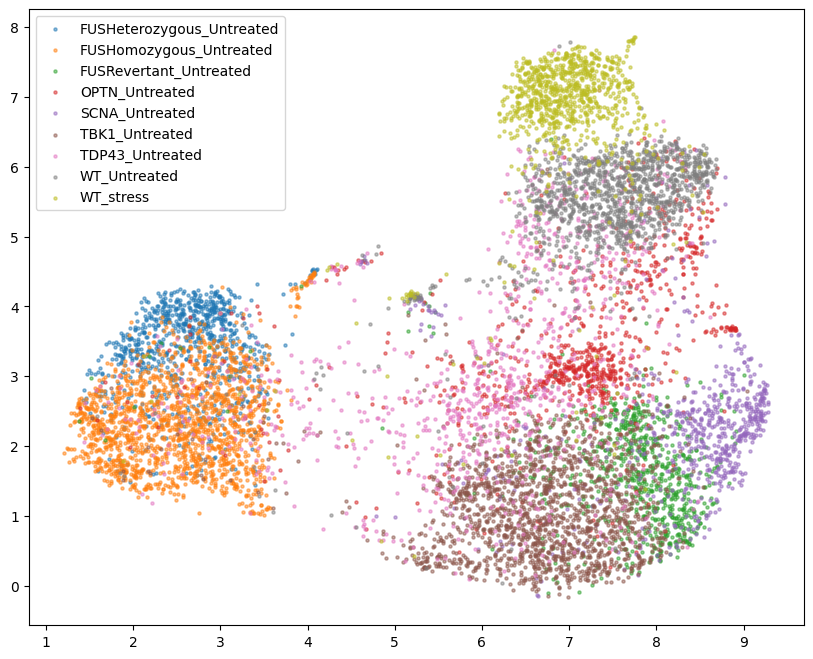

In [104]:
plt.figure(figsize=(10,8))
for i, l in enumerate(sm_unique_groups):
    print(f"[{i}/{len(sm_unique_groups)}] {l}")
    indx = np.where(sm_label_data == l)[0]
    emb_i = sm_emb_reduced[indx]
    plt.scatter(emb_i[...,0], emb_i[...,1], s=5, alpha=0.5)
plt.legend(sm_unique_groups)
plt.show()

-------

## Average the histograms per each label and save in a new dataframe (mean_spectra_per_marker)

In [84]:
mean_spectra_per_marker = hist_df.groupby('label').mean()
mean_spectra_per_marker

0         1         2         3     \
label                                                                      
ANXA11_FUSHeterozygous_Untreated  0.010842  0.015847  2.082569  0.020851   
ANXA11_FUSHomozygous_Untreated    0.023660  0.015934  2.163689  0.015451   
ANXA11_FUSRevertant_Untreated     0.045226  0.015634  2.269123  0.023451   
ANXA11_OPTN_Untreated             0.028796  0.029668  3.758290  0.041885   
ANXA11_SCNA_Untreated             0.017305  0.013597  1.788628  0.021014   
...                                    ...       ...       ...       ...   
mitotracker_SCNA_Untreated        0.023770  0.118033  1.864754  0.388525   
mitotracker_TBK1_Untreated        0.038293  0.076039  1.580963  0.415208   
mitotracker_TDP43_Untreated       0.030834  0.100210  1.670638  0.370708   
mitotracker_WT_Untreated          0.058786  0.085623  1.621725  0.374441   
mitotracker_WT_stress             0.037686  0.044698  1.801052  0.487292   

                                      4         5         6         7     \
label                                                                      
ANXA11_FUSHeterozygous_Untreated  0.308591  0.241868  0.043369  0.027523   
ANXA11_FUSHomozygous_Untreated    0.375664  0.122646  0.016417  0.028489   
ANXA11_FUSRevertant_Untreated     0.527080  0.132328  0.011725  0.027917   
ANXA11_OPTN_Untreated             0.359511  0.129145  0.018325  0.079407   
ANXA11_SCNA_Untreated             0.425216  0.121137  0.037083  0.029666   
...                                    ...       ...       ...       ...   
mitotracker_SCNA_Untreated        0.081148  0.046721  0.218852  0.200000   
mitotracker_TBK1_Untreated        0.055799  0.030088  0.300328  0.192560   
mitotracker_TDP43_Untreated       0.060266  0.025929  0.619481  0.186405   
mitotracker_WT_Untreated          0.057508  0.024281  0.182748  0.141853   
mitotracker_WT_stress             0.209465  0.025416  0.017528  0.064855   

                                      8         9     ...      2038      2039  \
label                                                 ...                       
ANXA11_FUSHeterozygous_Untreated  0.080067  0.003336  ...  0.076731  0.100083   
ANXA11_FUSHomozygous_Untreated    0.057943  0.009174  ...  0.063254  0.144375   
ANXA11_FUSRevertant_Untreated     0.045784  0.012842  ...  0.058626  0.148520   
ANXA11_OPTN_Untreated             0.048866  0.023560  ...  0.054974  0.126527   
ANXA11_SCNA_Untreated             0.077874  0.007417  ...  0.076638  0.064277   
...                                    ...       ...  ...       ...       ...   
mitotracker_SCNA_Untreated        0.072131  0.146721  ...  0.045902  0.032787   
mitotracker_TBK1_Untreated        0.065098  0.113786  ...  0.060722  0.071663   
mitotracker_TDP43_Untreated       0.051156  0.095305  ...  0.046952  0.076384   
mitotracker_WT_Untreated          0.048562  0.156550  ...  0.049840  0.068371   
mitotracker_WT_stress             0.067485  0.198072  ...  0.044698  0.035057   

                                      2040      2041      2042      2043  \
label                                                                      
ANXA11_FUSHeterozygous_Untreated  0.565471  0.139283  0.202669  0.000000   
ANXA11_FUSHomozygous_Untreated    0.605022  0.099952  0.197489  0.000000   
ANXA11_FUSRevertant_Untreated     0.624791  0.107203  0.208264  0.000000   
ANXA11_OPTN_Untreated             0.520942  0.191972  0.287958  0.000000   
ANXA11_SCNA_Untreated             0.332509  0.039555  0.176761  0.001236   
...                                    ...       ...       ...       ...   
mitotracker_SCNA_Untreated        0.435246  0.166393  1.772951  0.003279   
mitotracker_TBK1_Untreated        0.493982  0.116521  1.893873  0.002188   
mitotracker_TDP43_Untreated       0.573931  0.116328  1.581640  0.000701   
mitotracker_WT_Untreated          0.686262  0.116294  2.030032  0.000639   
mitotracker_WT_stress             1.343558  0.252410  1.579316  0.000876   

                 

## Correlate the indices histograms

In [85]:
corr = mean_spectra_per_marker.corr()
corr

0         1         2         3         4         5         6     \
0     1.000000 -0.125177 -0.292531 -0.218442  0.763614  0.049027 -0.107783   
1    -0.125177  1.000000 -0.153752  0.050057 -0.120809 -0.070884 -0.092667   
2    -0.292531 -0.153752  1.000000  0.086043 -0.439837 -0.091096 -0.011921   
3    -0.218442  0.050057  0.086043  1.000000 -0.211136 -0.459291  0.076078   
4     0.763614 -0.120809 -0.439837 -0.211136  1.000000  0.124250 -0.199101   
...        ...       ...       ...       ...       ...       ...       ...   
2043  0.106483  0.131002 -0.282819  0.058630  0.090066 -0.027170 -0.071474   
2044 -0.126858 -0.115332  0.007455  0.018704 -0.227795 -0.137747  0.389849   
2045 -0.115600 -0.129706 -0.275400  0.115763  0.163606 -0.298694  0.085244   
2046 -0.116522 -0.157626 -0.017206 -0.527175 -0.050732  0.749084 -0.054662   
2047  0.066678  0.791842 -0.406553  0.080732  0.008265 -0.040044 -0.117443   

          7         8         9     ...      2038      2039      2040  \
0    -0.113096  0.013610 -0.169984  ...  0.218183 -0.112327 -0.005070   
1    -0.066051  0.076864  0.457410  ... -0.219387  0.261994 -0.179479   
2    -0.059419 -0.267447  0.045168  ... -0.325759 -0.103464 -0.213219   
3    -0.140735  0.025632  0.209841  ... -0.445654 -0.148136 -0.035219   
4    -0.244381  0.161450 -0.188896  ...  0.367847 -0.156563  0.120478   
...        ...       ...       ...  ...       ...       ...       ...   
2043 -0.064436  0.155656  0.157675  ... -0.002166  0.191447 -0.072846   
2044  0.001267 -0.096735 -0.223957  ... -0.075402 -0.184390 -0.098935   
2045 -0.038693  0.131599 -0.175042  ...  0.020675 -0.257465  0.644640   
2046  0.106599 -0.059451 -0.247605  ...  0.546686  0.006798 -0.107478   
2047 -0.133875  0.048191  0.312860  ... -0.096767  0.333923 -0.173305   

          2041      2042      2043      2044      2045      2046      2047  
0    -0.173066 -0.192330  0.106483 -0.126858 -0.115600 -0.116522  0.066678  
1    -0.146302  0.092872  0.131002 -0.115332 -0.129706 -0.157626  0.791842  
2     0.248010  0.434428 -0.282819  0.007455 -0.275400 -0.017206 -0.406553  
3     0.258080  0.497738  0.058630  0.018704  0.115763 -0.527175  0.080732  
4     0.001433 -0.435237  0.090066 -0.227795  0.163606 -0.050732  0.008265  
...        ...       ...       ...       ...       ...       ...       ...  
2043 -0.170648 -0.108203  1.000000 -0.078044 -0.039203 -0.168301  0.491383  
2044 -0.114861  0.037717 -0.078044  1.000000 -0.032349 -0.139573 -0.126311  
2045  0.273130 -0.123933 -0.039203 -0.032349  1.000000 -0.209422 -0.106503  
2046 -0.276014 -0.296490 -0.168301 -0.139573 -0.209422  1.000000 -0.268207  
2047 -0.257903 -0.068260  0.491383 -0.126311 -0.106503 -0.268207  1.000000  

[2048 rows x 2048 columns]

## Plot correlation heatmap

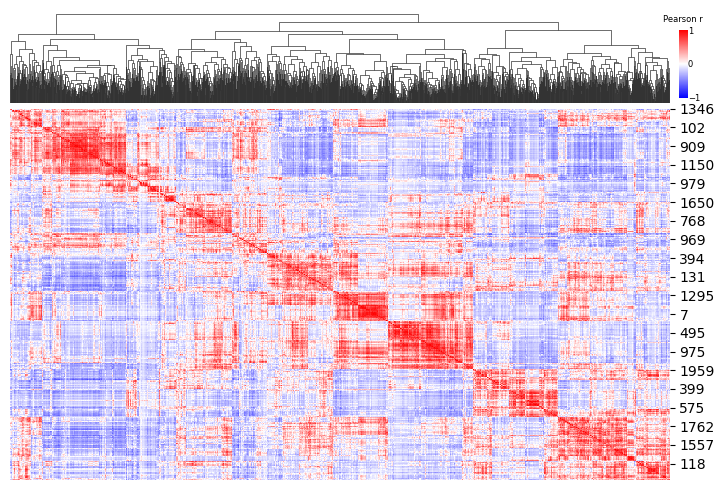

In [86]:
kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,5), xticklabels=False, **kws)
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
                                 clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
                                 0.01,                                                # width
                                 clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1) 
plt.show()
#clustermap.figure.savefig("codeword_idx_corr_heatmap.png")

## Cut the dendrogram to get indices clusters

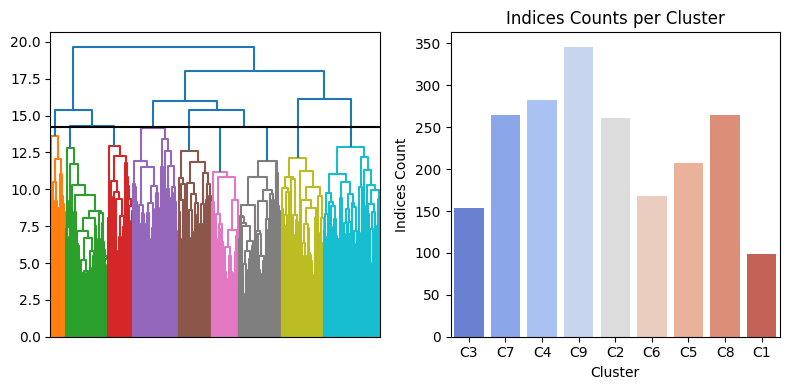

In [87]:
def get_clusters(clustermap, corr, cutoff = 14.2):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    den = scipy.cluster.hierarchy.dendrogram(clustermap.dendrogram_col.linkage,
                                             labels = corr.index,
                                             color_threshold=cutoff,
                                             no_labels=True,
                                             ax=axs[0])
    axs[0].axhline(cutoff, c='black', linestyle="-")

    def get_cluster_classes(den, label='ivl'):
        cluster_idxs = defaultdict(list)
        for c, pi in zip(den['color_list'], den['icoord']):
            for leg in pi[1:3]:
                i = (leg - 5.0) / 10.0
                if abs(i - int(i)) < 1e-5:
                    cluster_idxs[c].append(int(i))

        cluster_classes = {}
        for c, l in cluster_idxs.items():
            i_l = [den[label][i] for i in l]
            cluster_classes[c] = i_l

        return cluster_classes

    clusters = get_cluster_classes(den)
    cluster = []
    corr_with_clusters = corr.copy()

    for i in corr_with_clusters.index:
        included=False
        for j in clusters.keys():
            if i in clusters[j]:
                cluster.append(j)
                included=True
        if not included:
            cluster.append(None)

    corr_with_clusters["cluster"] = cluster

    # visualize the cluster counts
    sns.countplot(data=corr_with_clusters, x='cluster', palette='coolwarm', ax=axs[1])

    # Add labels and title
    axs[1].set_xlabel('Cluster')
    axs[1].set_ylabel('Indices Count')
    axs[1].set_title('Indices Counts per Cluster')

    plt.tight_layout()
    # Show
    plt.show()
    return corr_with_clusters

corr_with_clusters = get_clusters(clustermap, corr, cutoff = 14.2)

In [73]:
corr_with_clusters

0         1         2         3         4         5         6  \
0     1.000000 -0.125177 -0.292531 -0.218442  0.763614  0.049027 -0.107783   
1    -0.125177  1.000000 -0.153752  0.050057 -0.120809 -0.070884 -0.092667   
2    -0.292531 -0.153752  1.000000  0.086043 -0.439837 -0.091096 -0.011921   
3    -0.218442  0.050057  0.086043  1.000000 -0.211136 -0.459291  0.076078   
4     0.763614 -0.120809 -0.439837 -0.211136  1.000000  0.124250 -0.199101   
...        ...       ...       ...       ...       ...       ...       ...   
2043  0.106483  0.131002 -0.282819  0.058630  0.090066 -0.027170 -0.071474   
2044 -0.126858 -0.115332  0.007455  0.018704 -0.227795 -0.137747  0.389849   
2045 -0.115600 -0.129706 -0.275400  0.115763  0.163606 -0.298694  0.085244   
2046 -0.116522 -0.157626 -0.017206 -0.527175 -0.050732  0.749084 -0.054662   
2047  0.066678  0.791842 -0.406553  0.080732  0.008265 -0.040044 -0.117443   

             7         8         9  ...      2039      2040      2041  \
0    -0.113096  0.013610 -0.169984  ... -0.112327 -0.005070 -0.173066   
1    -0.066051  0.076864  0.457410  ...  0.261994 -0.179479 -0.146302   
2    -0.059419 -0.267447  0.045168  ... -0.103464 -0.213219  0.248010   
3    -0.140735  0.025632  0.209841  ... -0.148136 -0.035219  0.258080   
4    -0.244381  0.161450 -0.188896  ... -0.156563  0.120478  0.001433   
...        ...       ...       ...  ...       ...       ...       ...   
2043 -0.064436  0.155656  0.157675  ...  0.191447 -0.072846 -0.170648   
2044  0.001267 -0.096735 -0.223957  ... -0.184390 -0.098935 -0.114861   
2045 -0.038693  0.131599 -0.175042  ... -0.257465  0.644640  0.273130   
2046  0.106599 -0.059451 -0.247605  ...  0.006798 -0.107478 -0.276014   
2047 -0.133875  0.048191  0.312860  ...  0.333923 -0.173305 -0.257903   

          2042      2043      2044      2045      2046      2047  cluster  
0    -0.192330  0.106483 -0.126858 -0.115600 -0.116522  0.066678       C3  
1     0.092872  0.131002 -0.115332 -0.129706 -0.157626  0.791842       C7  
2     0.434428 -0.282819  0.007455 -0.275400 -0.017206 -0.406553       C4  
3     0.497738  0.058630  0.018704  0.115763 -0.527175  0.080732       C9  
4    -0.435237  0.090066 -0.227795  0.163606 -0.050732  0.008265       C3  
...        ...       ...       ...       ...       ...       ...      ...  
2043 -0.108203  1.000000 -0.078044 -0.039203 -0.168301  0.491383       C7  
2044  0.037717 -0.078044  1.000000 -0.032349 -0.139573 -0.126311       C9  
2045 -0.123933 -0.039203 -0.032349  1.000000 -0.209422 -0.106503       C8  
2046 -0.296490 -0.168301 -0.139573 -0.209422  1.000000 -0.268207       C2  
2047 -0.068260  0.491383 -0.126311 -0.106503 -0.268207  1.000000       C7  

[2048 rows x 2049 columns]

## plot the heatmaps with clusters and histograms of wanted labels

In [74]:
cluster_counts['count'].sum()

NameError: name 'cluster_counts' is not defined

In [75]:
labels = ['WT_Untreated']

def get_mean_hist(label):
    colormap_name = "viridis"
    kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
    clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,5), xticklabels=False, yticklabels=False, col_colors=corr_with_clusters.cluster, **kws)
    clustermap.ax_row_dendrogram.set_visible(False)

    # get the indices order from the dendrogram 
    hierarchical_order = clustermap.dendrogram_col.reordered_ind
    # filter wanted labels
    real_labels = []
    if label not in np.unique(hist_df.label):
        real_labels += [real_label for real_label in np.unique(hist_df.label) if label in real_label]
    else:
        real_labels.append(label)
    hist_df_cur = hist_df[hist_df.label.isin(real_labels)]
    # sum the histograms by labels and re-order by the indices order
    total_spectra_per_marker_ordered = hist_df_cur.groupby('label').mean()[hierarchical_order].sort_index() #TODO: change to mean?
    return total_spectra_per_marker_ordered



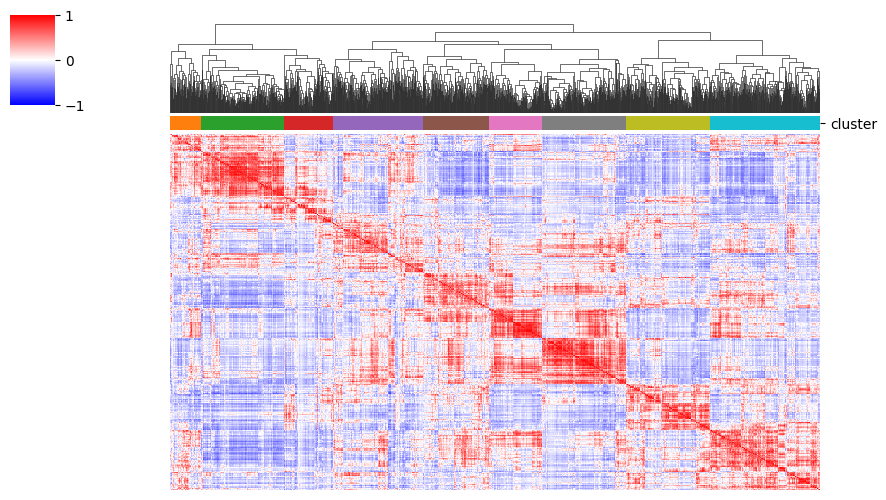

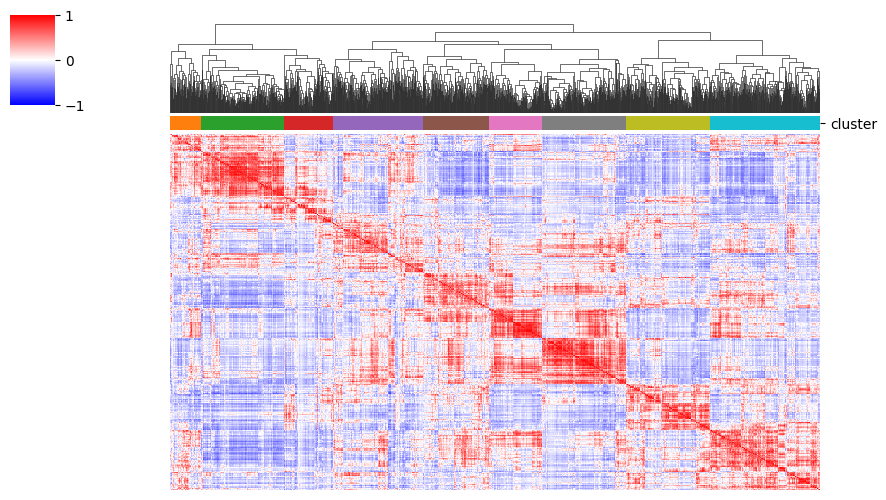

In [76]:
mean_hist_wt_untreated = get_mean_hist('WT_Untreated')
mean_hist_wt_stress = get_mean_hist('WT_stress')

get_marker_name = lambda x: [s[0] for s in x.index.str.split('_')]
assert get_marker_name(mean_hist_wt_untreated) == get_marker_name(mean_hist_wt_stress), "Error order"

assert mean_hist_wt_untreated.shape == mean_hist_wt_stress.shape, 'Error shape'


In [77]:
real_labels = get_marker_name(mean_hist_wt_untreated) 
real_labels

['ANXA11',
 'CD41',
 'CLTC',
 'Calreticulin',
 'DCP1A',
 'FMRP',
 'FUS',
 'G3BP1',
 'GM130',
 'KIF5A',
 'LAMP1',
 'NCL',
 'NEMO',
 'NONO',
 'PEX14',
 'PML',
 'PSD95',
 'PURA',
 'Phalloidin',
 'SCNA',
 'SQSTM1',
 'TDP43',
 'TIA1',
 'TOMM20',
 'mitotracker']

# iFFT

### WT analysis

In [32]:
mean_hist_wt_untreated_copy = mean_hist_wt_untreated.copy()
mean_hist_wt_untreated_copy.index = get_marker_name(mean_hist_wt_untreated_copy)

mean_hist_wt_untreated_copy

mean_hist_wt_stress_copy = mean_hist_wt_stress.copy()
mean_hist_wt_stress_copy.index = get_marker_name(mean_hist_wt_stress)

all(mean_hist_wt_stress_copy.index == mean_hist_wt_untreated_copy.index)

True

iFFT

In [4]:
from matplotlib import cm
from scipy.fft import ifft
from scipy.signal import hamming, convolve

In [ ]:
# SIGNAL (iFFT)

from matplotlib import cm
from scipy.fft import ifft
from scipy.signal import hamming, convolve

signals = ifft(mean_hist_wt_untreated_copy, axis=1)
signals_stress = ifft(mean_hist_wt_stress_copy, axis=1)

print(signals.shape, signals_stress.shape)

# Define the Hamming window
# Frequency Resolution: A larger window size (larger N) provides better frequency resolution. 
# This means you can distinguish between frequencies that are closer together. 
# If you're interested in analyzing or extracting fine-grained frequency information, choose a larger window size.
window = hamming(50)  # The window size is 11, you can adjust it



n = 20 # len(mean_hist_wt_untreated_copy.index)
# linestyles = ['-','--',':']
# markers = ['.','x','D','o']
for i in range(n):    
    plt.figure(figsize=(20,8))
    s =  convolve(signals[i], window, mode='same') / sum(window)
    s_stress =  convolve(signals_stress[i], window, mode='same') / sum(window)
    plt.plot(np.arange(len(signals[i])), s, linestyle='-', marker='o', alpha=1)
    plt.plot(np.arange(len(signals_stress[i])), s_stress, linestyle='--', marker='x', alpha=0.5)
    # plt.plot(np.arange(len(signals[i])), s, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=1)
    # plt.plot(np.arange(len(signals_stress[i])), s_stress, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=0.5)
    plt.title(mean_hist_wt_untreated_copy.index[i])
    plt.legend(['unstress','stress'])
    plt.show()
# plt.legend(mean_hist_wt_untreated_copy.index[:n])
# plt.tight_layout()
# plt.show()


In [101]:
hist_df[hist_df.label.str.contains('_WT_Untreated')]

0    1    2    3    4    5    6    7    8    9  ...  2039  2040  \
176     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...   0.0   4.0   
179     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   1.0   
180     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
181     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  ...   0.0   2.0   
183     0.0  1.0  0.0  0.0  3.0  0.0  0.0  0.0  1.0  1.0  ...   0.0   0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
320067  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...   0.0   1.0   
320071  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   1.0   
320076  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   3.0   
320081  2.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   1.0   
320082  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...   0.0   2.0   

        2041  2042  2043  2044  2045  2046  2047               label  
176      0.0   0.0   0.0   0.0   0.0   0.0   0.0  G3BP1_WT_Untreated  
179      1.0   0.0   0.0   0.0   0.0   0.0   0.0  G3BP1_WT_Untreated  
180      1.0   0.0   0.0   0.0   0.0   0.0   0.0  G3BP1_WT_Untreated  
181      0.0   0.0   0.0   0.0   1.0   0.0   0.0  G3BP1_WT_Untreated  
183      1.0   0.0   0.0   0.0   0.0   0.0   0.0  G3BP1_WT_Untreated  
...      ...   ...   ...   ...   ...   ...   ...                 ...  
320067   0.0   1.0   0.0   0.0   0.0   0.0   1.0  DCP1A_WT_Untreated  
320071   0.0   0.0   0.0   0.0   0.0   0.0  11.0  DCP1A_WT_Untreated  
320076   0.0   0.0   0.0   0.0   0.0   0.0   0.0  DCP1A_WT_Untreated  
320081   0.0   0.0   0.0   0.0   1.0   0.0   1.0  DCP1A_WT_Untreated  
320082   0.0   2.0   0.0   0.0   1.0   0.0   0.0  DCP1A_WT_Untreated  

[38393 rows x 2049 columns]

In [7]:
hist_df.label

0         batch7_16bit_no_downsample/FUSHomozygous/Untre...
1         batch7_16bit_no_downsample/FUSHomozygous/Untre...
2         batch7_16bit_no_downsample/FUSHomozygous/Untre...
3         batch7_16bit_no_downsample/FUSHomozygous/Untre...
4         batch7_16bit_no_downsample/FUSHomozygous/Untre...
                                ...                        
214620    batch7_16bit_no_downsample/FUSRevertant/Untrea...
214621    batch7_16bit_no_downsample/FUSRevertant/Untrea...
214622    batch7_16bit_no_downsample/FUSRevertant/Untrea...
214623    batch7_16bit_no_downsample/FUSRevertant/Untrea...
214624    batch7_16bit_no_downsample/FUSRevertant/Untrea...
Name: label, Length: 214625, dtype: object

In [8]:
sep = '/'#'_'
hist_wt_untreated =  hist_df[hist_df.label.str.contains(f'{sep}WT{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_tdp43_untreated = hist_df[hist_df.label.str.contains(f'{sep}TDP43{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_fusHetero_untreated = hist_df[hist_df.label.str.contains(f'{sep}FUSHeterozygous{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_fusHomo_untreated = hist_df[hist_df.label.str.contains(f'{sep}FUSHomozygous{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_fusRevertant_untreated = hist_df[hist_df.label.str.contains(f'{sep}FUSRevertant{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_optn_untreated = hist_df[hist_df.label.str.contains(f'{sep}OPTN{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_scna_untreated = hist_df[hist_df.label.str.contains(f'{sep}SCNA{sep}Untreated')].iloc[:,:-1].to_numpy()
hist_tbk1_untreated = hist_df[hist_df.label.str.contains(f'{sep}TBK1{sep}Untreated')].iloc[:,:-1].to_numpy()

hist_wt_untreated.shape, hist_tdp43_untreated.shape, hist_fusHetero_untreated.shape, hist_fusHomo_untreated.shape, hist_fusRevertant_untreated.shape, hist_optn_untreated.shape, hist_scna_untreated.shape, hist_tbk1_untreated.shape

((27082, 2048),
 (20625, 2048),
 (18466, 2048),
 (32302, 2048),
 (24864, 2048),
 (19763, 2048),
 (15381, 2048),
 (30786, 2048))

In [9]:
hist_wt_untreated =  ifft(hist_wt_untreated)
hist_tdp43_untreated = ifft(hist_tdp43_untreated)
hist_fusHetero_untreated = ifft(hist_fusHetero_untreated)
hist_fusHomo_untreated = ifft(hist_fusHomo_untreated)
hist_fusRevertant_untreated = ifft(hist_fusRevertant_untreated)
hist_optn_untreated = ifft(hist_optn_untreated)
hist_scna_untreated = ifft(hist_scna_untreated)
hist_tbk1_untreated = ifft(hist_tbk1_untreated)

In [10]:
print(hist_wt_untreated.shape, hist_tdp43_untreated.shape, hist_fusHetero_untreated.shape, hist_fusHomo_untreated.shape, hist_fusRevertant_untreated.shape, hist_optn_untreated.shape, hist_scna_untreated.shape, hist_tbk1_untreated.shape)


(27082, 2048) (20625, 2048) (18466, 2048) (32302, 2048) (24864, 2048) (19763, 2048) (15381, 2048) (30786, 2048)


(38393, 2048) (32785, 2048) (27676, 2048) (47908, 2048) (39961, 2048) (26373, 2048) (26290, 2048) (46518, 2048)
(2048,) (2048,) (2048,) (2048,) (2048,)


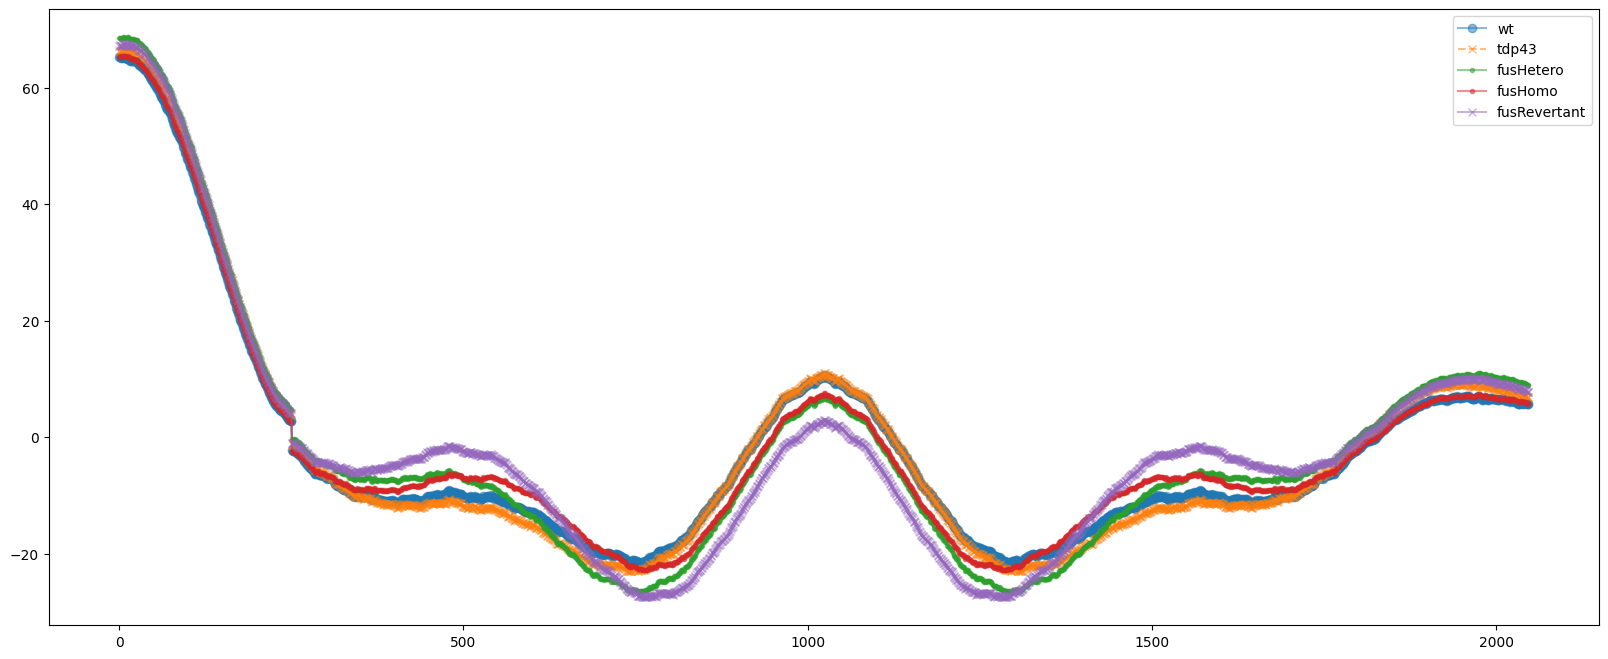

In [21]:

print(hist_wt_untreated.shape, hist_tdp43_untreated.shape, hist_fusHetero_untreated.shape, hist_fusHomo_untreated.shape, hist_fusRevertant_untreated.shape, hist_optn_untreated.shape, hist_scna_untreated.shape, hist_tbk1_untreated.shape)
n = min([hist_wt_untreated.shape[0], hist_tdp43_untreated.shape[0], hist_fusHetero_untreated.shape[0], hist_fusHomo_untreated.shape[0], hist_fusRevertant_untreated.shape[0], hist_optn_untreated.shape[0], hist_scna_untreated.shape[0], hist_tbk1_untreated.shape[0]])

signals_WT_sm = hist_wt_untreated[0]
for i in range(1, n):
    signals_WT_sm += hist_wt_untreated[i]

signals_tdp43_sm = hist_tdp43_untreated[0]
for i in range(1, n):
    signals_tdp43_sm +=  hist_tdp43_untreated[i]
    
signals_fusHetero_sm = hist_fusHetero_untreated[0]
for i in range(1, n):
    signals_fusHetero_sm +=  hist_fusHetero_untreated[i]
    
signals_fusHomo_sm = hist_fusHomo_untreated[0]
for i in range(1, n):
    signals_fusHomo_sm += hist_fusHomo_untreated[i]
    
signals_fusRevertant_sm = hist_fusRevertant_untreated[0]
for i in range(1, n):
    signals_fusRevertant_sm += hist_fusRevertant_untreated[i]
    
signals_optn_sm = hist_optn_untreated[0]
for i in range(1, n):
    signals_optn_sm += hist_optn_untreated[i]
    
signals_scna_sm = hist_scna_untreated[0]
for i in range(1, n):
    signals_scna_sm += hist_scna_untreated[i]
    
signals_tbk1_sm = hist_tbk1_untreated[0]
for i in range(1, n):
    signals_tbk1_sm += hist_tbk1_untreated[i]
    
print(signals_WT_sm.shape, signals_tdp43_sm.shape, signals_fusHetero_sm.shape, signals_fusHomo_sm.shape, signals_fusRevertant_sm.shape)
window = hamming(500)
s_wt =  convolve(signals_WT_sm, window, mode='same') / sum(window)
s_tdp43 =  convolve(signals_tdp43_sm, window, mode='same') / sum(window)
s_fusHetero =  convolve(signals_fusHetero_sm, window, mode='same') / sum(window)
s_fusHomo =  convolve(signals_fusHomo_sm, window, mode='same') / sum(window)
s_fusRevertant =  convolve(signals_fusRevertant_sm, window, mode='same') / sum(window)
s_optn =  convolve(signals_optn_sm, window, mode='same') / sum(window)
s_scna =  convolve(signals_scna_sm, window, mode='same') / sum(window)
s_tbk1 =  convolve(signals_tbk1_sm, window, mode='same') / sum(window)


plt.figure(figsize=(20,8))
alpha=0.5
plt.plot(np.arange(len(s_wt)), s_wt, linestyle='-', marker='o', alpha=alpha)
plt.plot(np.arange(len(s_tdp43)), s_tdp43, linestyle='--', marker='x', alpha=alpha)
plt.plot(np.arange(len(s_fusHetero)), s_fusHetero, linestyle='-', marker='.', alpha=alpha)
plt.plot(np.arange(len(s_fusHomo)), s_fusHomo, linestyle='-', marker='.', alpha=alpha)
plt.plot(np.arange(len(s_fusRevertant)), s_fusRevertant, linestyle='-', marker='x', alpha=alpha)
# plt.plot(np.arange(len(s_optn)), s_optn, linestyle='--', marker='o', alpha=alpha)
# plt.plot(np.arange(len(s_scna)), s_scna, linestyle='--', marker='x', alpha=alpha)
# plt.plot(np.arange(len(s_tbk1)), s_tbk1, linestyle='--', marker='.', alpha=alpha)

# plt.plot(np.arange(len(signals[i])), s, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=1)
# plt.plot(np.arange(len(signals_stress[i])), s_stress, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=0.5)
# plt.title(mean_hist_wt_untreated_copy.index[i])
plt.legend(['wt','tdp43','fusHetero','fusHomo','fusRevertant','optn','scna','tbk1'])
plt.show()

(27082, 2048) (20625, 2048) (18466, 2048) (32302, 2048) (24864, 2048) (19763, 2048) (15381, 2048) (30786, 2048)
(2048,) (2048,) (2048,) (2048,) (2048,)


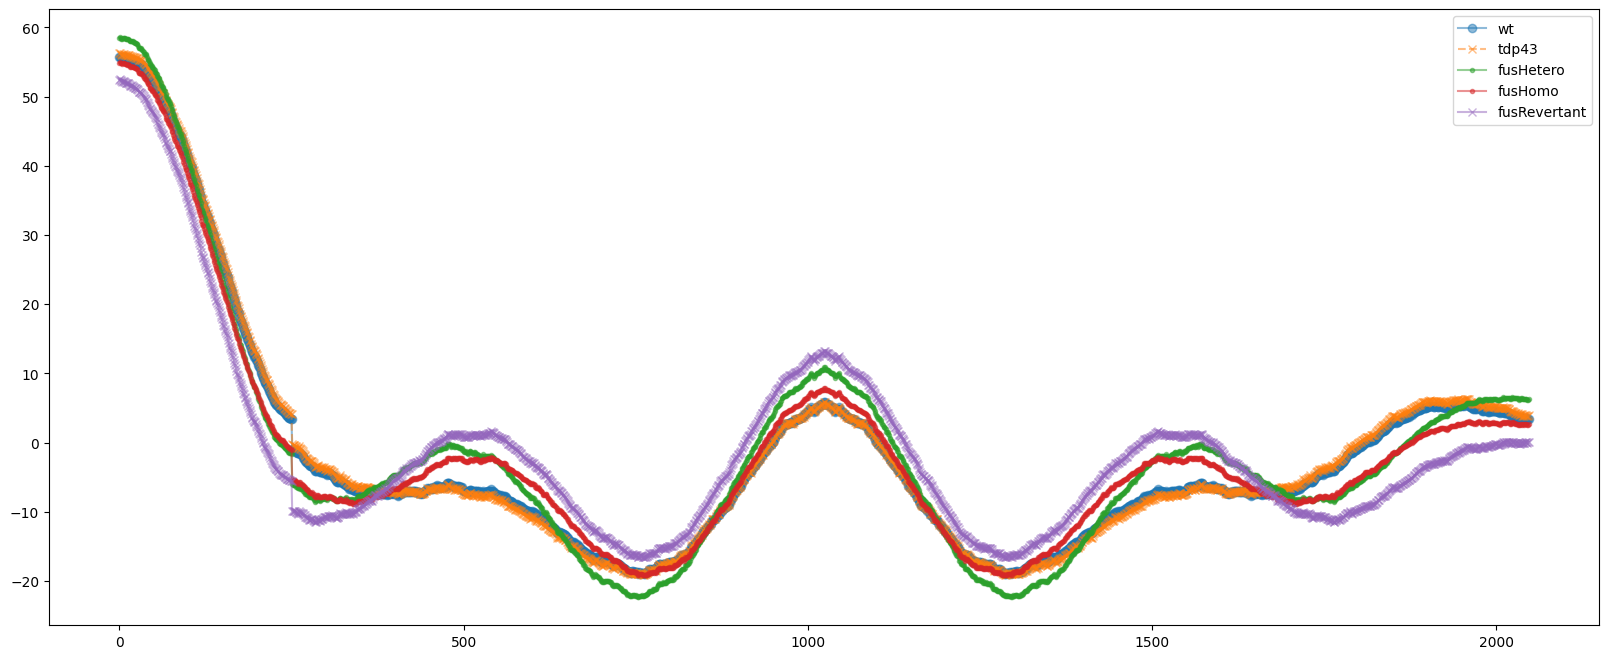

In [13]:
# b7 trainset


print(hist_wt_untreated.shape, hist_tdp43_untreated.shape, hist_fusHetero_untreated.shape, hist_fusHomo_untreated.shape, hist_fusRevertant_untreated.shape, hist_optn_untreated.shape, hist_scna_untreated.shape, hist_tbk1_untreated.shape)
n = min([hist_wt_untreated.shape[0], hist_tdp43_untreated.shape[0], hist_fusHetero_untreated.shape[0], hist_fusHomo_untreated.shape[0], hist_fusRevertant_untreated.shape[0], hist_optn_untreated.shape[0], hist_scna_untreated.shape[0], hist_tbk1_untreated.shape[0]])

signals_WT_sm = hist_wt_untreated[0]
for i in range(1, n):
    signals_WT_sm += hist_wt_untreated[i]

signals_tdp43_sm = hist_tdp43_untreated[0]
for i in range(1, n):
    signals_tdp43_sm +=  hist_tdp43_untreated[i]
    
signals_fusHetero_sm = hist_fusHetero_untreated[0]
for i in range(1, n):
    signals_fusHetero_sm +=  hist_fusHetero_untreated[i]
    
signals_fusHomo_sm = hist_fusHomo_untreated[0]
for i in range(1, n):
    signals_fusHomo_sm += hist_fusHomo_untreated[i]
    
signals_fusRevertant_sm = hist_fusRevertant_untreated[0]
for i in range(1, n):
    signals_fusRevertant_sm += hist_fusRevertant_untreated[i]
    
signals_optn_sm = hist_optn_untreated[0]
for i in range(1, n):
    signals_optn_sm += hist_optn_untreated[i]
    
signals_scna_sm = hist_scna_untreated[0]
for i in range(1, n):
    signals_scna_sm += hist_scna_untreated[i]
    
signals_tbk1_sm = hist_tbk1_untreated[0]
for i in range(1, n):
    signals_tbk1_sm += hist_tbk1_untreated[i]
    
print(signals_WT_sm.shape, signals_tdp43_sm.shape, signals_fusHetero_sm.shape, signals_fusHomo_sm.shape, signals_fusRevertant_sm.shape)
window = hamming(500)
s_wt =  convolve(signals_WT_sm, window, mode='same') / sum(window)
s_tdp43 =  convolve(signals_tdp43_sm, window, mode='same') / sum(window)
s_fusHetero =  convolve(signals_fusHetero_sm, window, mode='same') / sum(window)
s_fusHomo =  convolve(signals_fusHomo_sm, window, mode='same') / sum(window)
s_fusRevertant =  convolve(signals_fusRevertant_sm, window, mode='same') / sum(window)
s_optn =  convolve(signals_optn_sm, window, mode='same') / sum(window)
s_scna =  convolve(signals_scna_sm, window, mode='same') / sum(window)
s_tbk1 =  convolve(signals_tbk1_sm, window, mode='same') / sum(window)


plt.figure(figsize=(20,8))
alpha=0.5
plt.plot(np.arange(len(s_wt)), s_wt, linestyle='-', marker='o', alpha=alpha)
plt.plot(np.arange(len(s_tdp43)), s_tdp43, linestyle='--', marker='x', alpha=alpha)
plt.plot(np.arange(len(s_fusHetero)), s_fusHetero, linestyle='-', marker='.', alpha=alpha)
plt.plot(np.arange(len(s_fusHomo)), s_fusHomo, linestyle='-', marker='.', alpha=alpha)
plt.plot(np.arange(len(s_fusRevertant)), s_fusRevertant, linestyle='-', marker='x', alpha=alpha)
# plt.plot(np.arange(len(s_optn)), s_optn, linestyle='--', marker='o', alpha=alpha)
# plt.plot(np.arange(len(s_scna)), s_scna, linestyle='--', marker='x', alpha=alpha)
# plt.plot(np.arange(len(s_tbk1)), s_tbk1, linestyle='--', marker='.', alpha=alpha)

# plt.plot(np.arange(len(signals[i])), s, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=1)
# plt.plot(np.arange(len(signals_stress[i])), s_stress, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=0.5)
# plt.title(mean_hist_wt_untreated_copy.index[i])
plt.legend(['wt','tdp43','fusHetero','fusHomo','fusRevertant','optn','scna','tbk1'])
plt.show()

(2048,) (2048,)


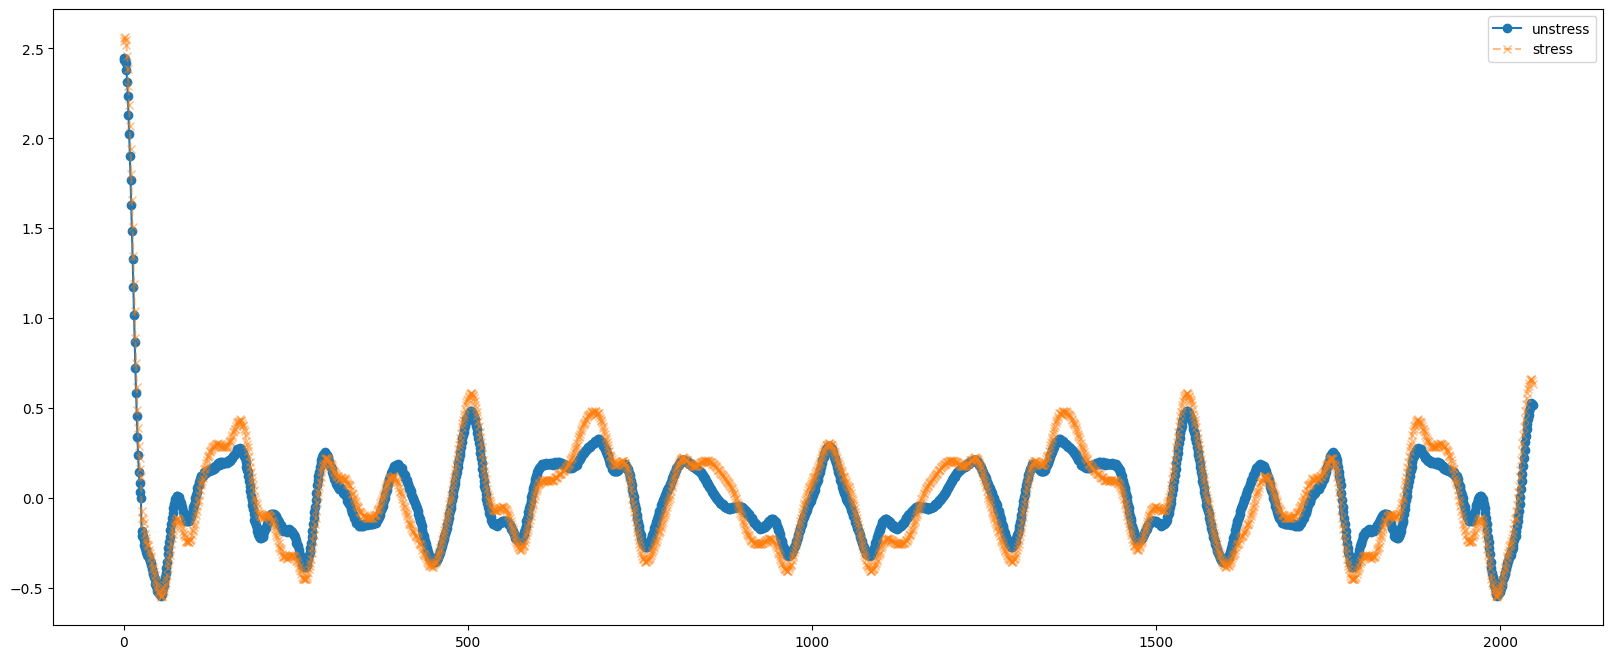

In [76]:

signals_sm = signals[0]
for i in range(1, len(signals)):
    signals_sm += signals[i]

signals_stress_sm = signals_stress[0]
for i in range(1, len(signals_stress)):
    signals_stress_sm +=  signals_stress[i]
    
print(signals_sm.shape, signals_stress_sm.shape)
window = hamming(50)
s =  convolve(signals_sm, window, mode='same') / sum(window)
s_stress =  convolve(signals_stress_sm, window, mode='same') / sum(window)

plt.figure(figsize=(20,8))
plt.plot(np.arange(len(s)), s, linestyle='-', marker='o', alpha=1)
plt.plot(np.arange(len(s_stress)), s_stress, linestyle='--', marker='x', alpha=0.5)
# plt.plot(np.arange(len(signals[i])), s, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=1)
# plt.plot(np.arange(len(signals_stress[i])), s_stress, linestyle=linestyles[i%len(linestyles)], marker=markers[i%len(markers)], alpha=0.5)
# plt.title(mean_hist_wt_untreated_copy.index[i])
plt.legend(['unstress','stress'])
plt.show()

### DIFF

In [13]:
mean_hist_wt_untreated_copy = mean_hist_wt_untreated.copy()
mean_hist_wt_untreated_copy.index = get_marker_name(mean_hist_wt_untreated_copy)

mean_hist_wt_stress_copy = mean_hist_wt_stress.copy()
mean_hist_wt_stress_copy.index = get_marker_name(mean_hist_wt_stress)


diff = mean_hist_wt_stress_copy.subtract(mean_hist_wt_untreated_copy, axis='index')
diff

1346      207       1459      1773      911       487   \
ANXA11        0.144700  0.015110 -0.004391  0.472194  0.001117 -0.004446   
CD41          0.096910 -0.005648 -0.007564  0.892703 -0.047488 -0.002868   
CLTC          0.134976  0.042753 -0.008775  0.492923  0.067016 -0.014987   
Calreticulin  0.033889  0.026977 -0.001632  0.143244  0.059095 -0.031751   
DCP1A        -0.023121 -0.011201 -0.010951  0.113896 -0.007556 -0.001220   
FMRP          0.350631 -0.178738 -0.010785 -0.465454 -0.150465 -0.070748   
FUS           1.186606  0.009734  0.177117  0.818442  0.012425  0.001233   
G3BP1         0.334571  0.022899  0.016781  1.714346 -0.488568 -0.197726   
GM130        -0.028579  0.002317  0.013150 -0.235959 -0.003628 -0.000125   
KIF5A        -0.032398 -0.007750 -0.009060  0.373000 -0.013125 -0.025554   
LAMP1         0.125672 -0.000780  0.011165  0.404032 -0.004638  0.002867   
NCL          -0.011492 -0.036804  0.040309 -0.701114  0.037199 -0.000648   
NEMO         -0.008197  0.002237  0.001424  0.014521 -0.002846  0.010530   
NONO         -0.126567  0.054420  0.151824  0.351610  0.089360 -0.008238   
PEX14         0.095009  0.000772  0.005193  0.197916  0.009338  0.002374   
PML           0.093310  0.013880  0.022208  0.677851  0.000336 -0.001442   
PSD95         0.017509  0.009739  0.009766  0.017073 -0.000603  0.001337   
PURA         -0.367489 -0.077778 -0.027841 -0.204851 -0.090677  0.007188   
Phalloidin    0.010014  0.014167  0.005032 -0.477386  0.176472 -0.061468   
SCNA          0.083844  0.006196  0.011670  0.099313 -0.004186  0.002695   
SQSTM1       -0.007337  0.013375  0.048945 -0.562894  0.038480  0.004437   
TDP43        -0.117047 -0.083555  0.047452  1.336964 -0.008534 -0.075786   
TIA1          0.035760  0.001693  0.016523  0.264333 -0.023737  0.000201   
TOMM20        0.245150 -0.060954  0.001999  0.392607 -0.045203  0.037504   
mitotracker   0.099984  0.046862  0.083357  0.491397  0.032779  0.016600   

                  840       587       1757      409   ...      1178      1219  \
ANXA11       -0.011622  0.312703  0.081916 -0.546793  ... -0.174280 -0.022689   
CD41         -0.092793  0.001228 -0.017084 -0.002344  ...  0.142297  0.032089   
CLTC         -0.047507  0.005783  0.026865 -0.002548  ... -0.040847 -0.024409   
Calreticulin  0.000703 -0.002276  0.005055 -0.003773  ...  0.024444  0.099268   
DCP1A        -0.002065 -0.000892  0.003552 -0.002425  ...  0.275846  0.229455   
FMRP         -0.099032  0.024638 -0.005607  0.006538  ... -0.059026  0.345920   
FUS           0.124101 -0.002221  0.009913  0.004914  ...  0.041954  0.036443   
G3BP1        -2.496391  0.012313 -0.009161  0.001889  ...  0.179479  0.169090   
GM130         0.007903  0.003754  0.002498  0.001114  ...  0.004000  0.005737   
KIF5A        -0.297910 -0.008938  0.003665  0.004045  ...  0.024029  0.032750   
LAMP1         0.001812  0.001351  0.023502  0.003026  ...  0.055591 -0.050250   
NCL          -0.227081 -0.001394 -0.013123  0.006778  ... -0.155521  0.008366   
NEMO          0.001486  0.000266 -0.022699  0.002707  ... -0.014248  0.006134   
NONO          0.070781 -0.042062  0.003596 -0.008089  ...  0.251944 -0.212901   
PEX14        -0.002720  0.009040  0.002270 -0.034204  ... -0.134043 -0.020830   
PML          -0.016247  0.004930 -0.000307 -0.003925  ...  0.382514  0.325363   
PSD95        -0.011672 -0.003787 -0.007296  0.008108  ... -0.000613 -0.018844   
PURA         -0.022784  0.017925  0.014521  0.012200  ... -0.029513 -0.131602   
Phalloidin   -0.002138  0.003818  0.079139  0.094931  ... -0.819420  0.317331   
SCNA          0.010160  0.010488 -0.002678  0.019174  ... -0.094378  0.076891   
SQSTM1        0.011463  0.161556  0.004528 -0.025284  ... -0.501125  0.072634   
TDP43         0.795007 -0.018384 -0.050504 -0.003973  ...  0.178228 -0.390342   
TIA1         -0.010400 -0.000356  0.005332 -0.001992  ...  0.060988  0.060676   
TOMM20       -0.002568 -0.004489  0.033339 -0.022047  ...  0.122716 -0.103746   
mitotracker   0.

In [ ]:
# cur_groups = real_labels
# colormap_name = "viridis"

# # make room for the histograms in the plot
# hist_height = 0.05
# clustermap.fig.subplots_adjust(top=hist_height*len(cur_groups)+1, bottom=hist_height*len(cur_groups))

# # add axes for the histograms
# axs=[]
# for i, label in enumerate(cur_groups):
#     axs.append(clustermap.fig.add_axes([clustermap.ax_heatmap.get_position().x0, 0+i*hist_height, clustermap.ax_heatmap.get_position().width, hist_height]))


# # create colors
# colors = sns.color_palette(colormap_name, n_colors=len(cur_groups))

# # plot the histograms
# for i, label in enumerate(cur_groups[::-1]):
#     d = diff.loc[label, :]
#     #d.plot(ax=axs[i], kind='area',linewidth=0.2)
#     axs[i].fill_between(range(len(d)), d, color=colors[i], label=label, linewidth=0.3)
#     axs[i].set_xticklabels([])
#     axs[i].set_xticks([])
#     # axs[i].set_yticklabels([])
#     # axs[i].set_yticks([])
#     axs[i].tick_params(axis='y', labelsize=4, length=0, pad=0.1)
#     splitted_label = label.split("_")
#     label_for_plot = ''
#     if len(cur_markers)>1:
#         label_for_plot+= f'{splitted_label[0]}_'
#     if len(cur_cell_lines)>1:
#         label_for_plot+= f'{splitted_label[1]}_'
#     if len(cur_conditions)>1:
#         label_for_plot+= f'{splitted_label[2]}'
#     if label_for_plot.endswith("_"):
#         label_for_plot = label_for_plot[:-1]
#     axs[i].text(1.02, 0.5, label_for_plot, transform=axs[i].transAxes,
#                 rotation=0, va='center', ha='left')

#     #ax.tick_params(axis='y', labelsize=8)
#     axs[i].spines['bottom'].set_color('lightgray')
#     axs[i].spines['top'].set_color('lightgray')
#     axs[i].spines['right'].set_color('lightgray')
#     axs[i].spines['left'].set_color('lightgray')
#     axs[i].margins(x=0.01)
    
#     prev_count = 0
#     for j, cluster in enumerate(cluster_counts.cluster):
#         cur_count = cluster_counts.iloc[j]['count']
#         cluster_end = cur_count + prev_count
#         x_pos = cluster_end
#         axs[i].axvline(x=x_pos, color='black',linestyle="-", linewidth=0.1)
#         print(cur_count, cluster_end)
#         prev_count = cur_count
#     break
# # fix the cbar appearance 
# clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
#                                  clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
#                                  0.01,                                                # width
#                                  clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
# clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
# clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1)


In [14]:
diff

1346      207       1459      1773      911       487   \
ANXA11        0.144700  0.015110 -0.004391  0.472194  0.001117 -0.004446   
CD41          0.096910 -0.005648 -0.007564  0.892703 -0.047488 -0.002868   
CLTC          0.134976  0.042753 -0.008775  0.492923  0.067016 -0.014987   
Calreticulin  0.033889  0.026977 -0.001632  0.143244  0.059095 -0.031751   
DCP1A        -0.023121 -0.011201 -0.010951  0.113896 -0.007556 -0.001220   
FMRP          0.350631 -0.178738 -0.010785 -0.465454 -0.150465 -0.070748   
FUS           1.186606  0.009734  0.177117  0.818442  0.012425  0.001233   
G3BP1         0.334571  0.022899  0.016781  1.714346 -0.488568 -0.197726   
GM130        -0.028579  0.002317  0.013150 -0.235959 -0.003628 -0.000125   
KIF5A        -0.032398 -0.007750 -0.009060  0.373000 -0.013125 -0.025554   
LAMP1         0.125672 -0.000780  0.011165  0.404032 -0.004638  0.002867   
NCL          -0.011492 -0.036804  0.040309 -0.701114  0.037199 -0.000648   
NEMO         -0.008197  0.002237  0.001424  0.014521 -0.002846  0.010530   
NONO         -0.126567  0.054420  0.151824  0.351610  0.089360 -0.008238   
PEX14         0.095009  0.000772  0.005193  0.197916  0.009338  0.002374   
PML           0.093310  0.013880  0.022208  0.677851  0.000336 -0.001442   
PSD95         0.017509  0.009739  0.009766  0.017073 -0.000603  0.001337   
PURA         -0.367489 -0.077778 -0.027841 -0.204851 -0.090677  0.007188   
Phalloidin    0.010014  0.014167  0.005032 -0.477386  0.176472 -0.061468   
SCNA          0.083844  0.006196  0.011670  0.099313 -0.004186  0.002695   
SQSTM1       -0.007337  0.013375  0.048945 -0.562894  0.038480  0.004437   
TDP43        -0.117047 -0.083555  0.047452  1.336964 -0.008534 -0.075786   
TIA1          0.035760  0.001693  0.016523  0.264333 -0.023737  0.000201   
TOMM20        0.245150 -0.060954  0.001999  0.392607 -0.045203  0.037504   
mitotracker   0.099984  0.046862  0.083357  0.491397  0.032779  0.016600   

                  840       587       1757      409   ...      1178      1219  \
ANXA11       -0.011622  0.312703  0.081916 -0.546793  ... -0.174280 -0.022689   
CD41         -0.092793  0.001228 -0.017084 -0.002344  ...  0.142297  0.032089   
CLTC         -0.047507  0.005783  0.026865 -0.002548  ... -0.040847 -0.024409   
Calreticulin  0.000703 -0.002276  0.005055 -0.003773  ...  0.024444  0.099268   
DCP1A        -0.002065 -0.000892  0.003552 -0.002425  ...  0.275846  0.229455   
FMRP         -0.099032  0.024638 -0.005607  0.006538  ... -0.059026  0.345920   
FUS           0.124101 -0.002221  0.009913  0.004914  ...  0.041954  0.036443   
G3BP1        -2.496391  0.012313 -0.009161  0.001889  ...  0.179479  0.169090   
GM130         0.007903  0.003754  0.002498  0.001114  ...  0.004000  0.005737   
KIF5A        -0.297910 -0.008938  0.003665  0.004045  ...  0.024029  0.032750   
LAMP1         0.001812  0.001351  0.023502  0.003026  ...  0.055591 -0.050250   
NCL          -0.227081 -0.001394 -0.013123  0.006778  ... -0.155521  0.008366   
NEMO          0.001486  0.000266 -0.022699  0.002707  ... -0.014248  0.006134   
NONO          0.070781 -0.042062  0.003596 -0.008089  ...  0.251944 -0.212901   
PEX14        -0.002720  0.009040  0.002270 -0.034204  ... -0.134043 -0.020830   
PML          -0.016247  0.004930 -0.000307 -0.003925  ...  0.382514  0.325363   
PSD95        -0.011672 -0.003787 -0.007296  0.008108  ... -0.000613 -0.018844   
PURA         -0.022784  0.017925  0.014521  0.012200  ... -0.029513 -0.131602   
Phalloidin   -0.002138  0.003818  0.079139  0.094931  ... -0.819420  0.317331   
SCNA          0.010160  0.010488 -0.002678  0.019174  ... -0.094378  0.076891   
SQSTM1        0.011463  0.161556  0.004528 -0.025284  ... -0.501125  0.072634   
TDP43         0.795007 -0.018384 -0.050504 -0.003973  ...  0.178228 -0.390342   
TIA1         -0.010400 -0.000356  0.005332 -0.001992  ...  0.060988  0.060676   
TOMM20       -0.002568 -0.004489  0.033339 -0.022047  ...  0.122716 -0.103746   
mitotracker   0.

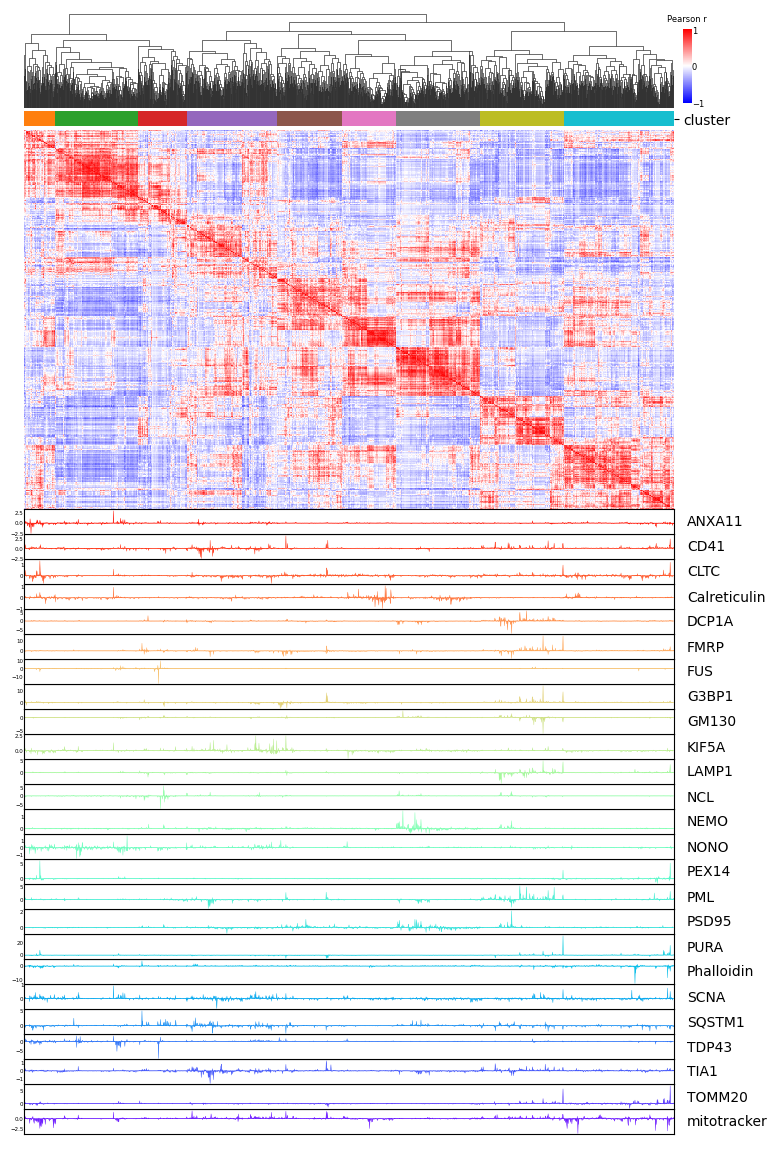

In [15]:
labels = ['WT_Untreated']
colormap_name = "rainbow"
kws = dict(cbar_kws=dict(ticks=[-1,0,1]))
clustermap = sns.clustermap(corr, center=0, cmap='bwr', vmin=-1, vmax=1, figsize=(9,5), xticklabels=False, yticklabels=False, col_colors=corr_with_clusters.cluster, **kws)
clustermap.ax_row_dendrogram.set_visible(False)

# get the indices order from the dendrogram 
hierarchical_order = clustermap.dendrogram_col.reordered_ind
# filter wanted labels
real_labels = real_labels = get_marker_name(mean_hist_wt_untreated) 
# for label in labels:
#     if label not in np.unique(hist_df.label):
#         real_labels += [real_label for real_label in np.unique(hist_df.label) if label in real_label]
#     else:
#         real_labels.append(label)
# hist_df_cur = hist_df[hist_df.label.isin(real_labels)]
cur_groups = real_labels
# splitted_labels = hist_df_cur.label.str.split("_")
# cur_markers = np.unique(splitted_labels.str[0])
# cur_cell_lines = np.unique(splitted_labels.str[1])
# cur_conditions = np.unique(splitted_labels.str[2])
# sum the histograms by labels and re-order by the indices order
# total_spectra_per_marker_ordered = hist_df_cur.groupby('label').mean()[hierarchical_order] #TODO: change to mean?
# total_spectra_per_marker_ordered

# calc clusters locations
cluster_counts = pd.DataFrame(corr_with_clusters.cluster.value_counts()).reset_index().sort_values(by='cluster')
cluster_positions = clustermap.ax_col_dendrogram.get_position()
num_samples = len(clustermap.dendrogram_col.data)
line_positions = [cluster_positions.x0 + i * (cluster_positions.width / num_samples) for i in range(1, num_samples)]

    
# make room for the histograms in the plot
hist_height = 0.05
clustermap.fig.subplots_adjust(top=hist_height*len(cur_groups)+1, bottom=hist_height*len(cur_groups))

# add axes for the histograms
axs=[]
for i, label in enumerate(cur_groups):
    axs.append(clustermap.fig.add_axes([clustermap.ax_heatmap.get_position().x0, 0+i*hist_height, clustermap.ax_heatmap.get_position().width, hist_height]))

# create colors
colors = sns.color_palette(colormap_name, n_colors=len(cur_groups))

# plot the histograms
for i, label in enumerate(cur_groups[::-1]):
    d = diff.loc[label, :]
    #d.plot(ax=axs[i], kind='area',linewidth=0.2)
    axs[i].fill_between(range(len(d)), d, color=colors[i], label=label, linewidth=0.3)
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    # axs[i].set_yticklabels([])
    # axs[i].set_yticks([])
    axs[i].tick_params(axis='y', labelsize=4, length=0, pad=0.1)
    # splitted_label = label.split("_")
    # label_for_plot = ''
    # if len(cur_markers)>1:
    #     label_for_plot+= f'{splitted_label[0]}_'
    # if len(cur_cell_lines)>1:
    #     label_for_plot+= f'{splitted_label[1]}_'
    # if len(cur_conditions)>1:
    #     label_for_plot+= f'{splitted_label[2]}'
    # if label_for_plot.endswith("_"):
    #     label_for_plot = label_for_plot[:-1]
    axs[i].text(1.02, 0.5, label, transform=axs[i].transAxes,
                rotation=0, va='center', ha='left')

    #ax.tick_params(axis='y', labelsize=8)
    # axs[i].spines['bottom'].set_color('lightgray')
    # axs[i].spines['top'].set_color('lightgray')
    # axs[i].spines['right'].set_color('lightgray')
    # axs[i].spines['left'].set_color('lightgray')
    axs[i].margins(x=0.001)
    
    # prev_count = 0
    # for j, cluster in enumerate(cluster_counts.cluster):
    #     cur_count = cluster_counts.iloc[j]['count']
    #     cluster_end = cur_count + prev_count
    #     x_pos = cluster_end
    #     axs[i].axvline(x=x_pos, color='black',linestyle="-", linewidth=0.1)
    #     print(cur_count, cluster_end)
    #     prev_count = cur_count
    
# fix the cbar appearance 
clustermap.ax_cbar.set_position([clustermap.ax_col_dendrogram.get_position().x1+0.01, # x location 
                                 clustermap.ax_col_dendrogram.get_position().y0+0.01, # y location
                                 0.01,                                                # width
                                 clustermap.ax_col_dendrogram.get_position().height-0.05]) #height
clustermap.ax_cbar.set_title('Pearson r',fontsize=6)
clustermap.cax.tick_params(axis='y', labelsize=6, length=0, pad=0.1)

# # Add dashed lines to the plot
# for pos in line_positions:
#     plt.axvline(x=pos, color='black', linestyle='--', linewidth=0.5)
#     #return None
    


In [16]:
# img = next(iter(dataloader))['image'].detach().cpu().numpy()
# torch.cuda.empty_cache()
import datetime
import os
import sys




sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

import numpy as np
import pandas as pd
import logging
import  torch

from src.common.lib.utils import get_if_exists, load_config_file
from src.common.lib.model import Model
from src.common.lib.data_loader import get_dataloader
from src.datasets.dataset_spd import DatasetSPD
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import resize


%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps
MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps
Modules to reload:
all-except-skipped

Modules to skip:



In [17]:
config_model = load_config_file("./src/models/neuroself/configs/model_config/TLNeuroselfB78NoDSModelConfig", 'model')


model = Model(config_model)

model.load_model(num_fc_output_classes=225)

2023-10-05 10:22:36 INFO [TLNeuroselfB78NoDSModelConfig] Init (log path: /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/logs/051023_102236_339031.log)
2023-10-05 10:22:36 INFO [TLNeuroselfB78NoDSModelConfig] MOMAPS_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps, MOMAPS_DATA_HOME=/home/labs/hornsteinlab/Collaboration/MOmaps/input
2023-10-05 10:22:36 INFO Creating the model
2023-10-05 10:22:36 INFO early_stop_patience=10, learn_rate=0.0002,                batch_size=4, max_epoch=100
2023-10-05 10:22:36 INFO Init model object (fc output: 225)
2023-10-05 10:22:37 INFO Loading model from checkpoint /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/checkpoints/checkpoint_ep21.chkp
2023-10-05 10:22:37 WARNING !!!!!!! NOTE !!!!!!!!!!! Loading to CPU!!!!
2023-10-05 10:22:40 INFO /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/checkpoints/checkpoint_ep21.chkp h

2023-10-05 14:11:12 INFO [infer_embeddings] output_layer = vqvec2
2023-10-05 14:11:13 INFO [cyto vq] encoding_onehot shape: (torch.Size([625, 2048])) torch.Size([1, 25, 25, 64])
2023-10-05 14:11:13 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 64])) (torch.Size([1, 64, 25, 25]))
2023-10-05 14:11:13 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 2048])) encoding_onehot: torch.Size([1, 2048, 25, 25])
2023-10-05 14:11:13 INFO [cyto vq] unsplit (torch.Size([625])) encoding_indices: torch.Size([1, 1, 25, 25])
2023-10-05 14:11:14 INFO [cyto vq] encoding_onehot shape: (torch.Size([144, 2048])) torch.Size([1, 4, 4, 576])
2023-10-05 14:11:14 INFO [cyto vq] unsplit (torch.Size([1, 4, 4, 576])) (torch.Size([1, 576, 4, 4]))
2023-10-05 14:11:14 INFO [cyto vq] unsplit (torch.Size([1, 12, 12, 2048])) encoding_onehot: torch.Size([1, 2048, 12, 12])
2023-10-05 14:11:14 INFO [cyto vq] unsplit (torch.Size([144])) encoding_indices: torch.Size([1, 1, 12, 12])
2023-10-05 14:11:14 INFO [infer_embeddings] out

torch.Size([1, 576, 25, 25])


2023-10-05 14:11:15 INFO [cyto vq] encoding_onehot shape: (torch.Size([625, 2048])) torch.Size([1, 25, 25, 64])
2023-10-05 14:11:15 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 64])) (torch.Size([1, 64, 25, 25]))
2023-10-05 14:11:15 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 2048])) encoding_onehot: torch.Size([1, 2048, 25, 25])
2023-10-05 14:11:15 INFO [cyto vq] unsplit (torch.Size([625])) encoding_indices: torch.Size([1, 1, 25, 25])


torch.Size([1, 64, 25, 25])


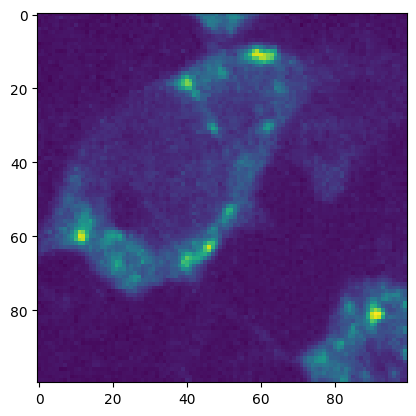

In [368]:

# images = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample/WT/Untreated/G3BP1/rep1_R11_w3confCy5_s201_panelA_WT_processed.npy")
images = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample/WT/stress/G3BP1/rep1_R11_w3confCy5_s1_panelA_WT_processed.npy")

images = np.transpose(images, (0,3,1,2))

img = images[[0]]
img_original = img
plt.imshow(img[0,0,...])

emb2 = model.model.infer_embeddings(img, 'vqvec2')
emb2 = torch.from_numpy(emb2)
emb2 = resize(emb2, (25,25), interpolation=InterpolationMode.NEAREST)
print(emb2.shape)

emb1 = model.model.infer_embeddings(img, 'vqvec1')
emb1 = torch.from_numpy(emb1)
print(emb1.shape)


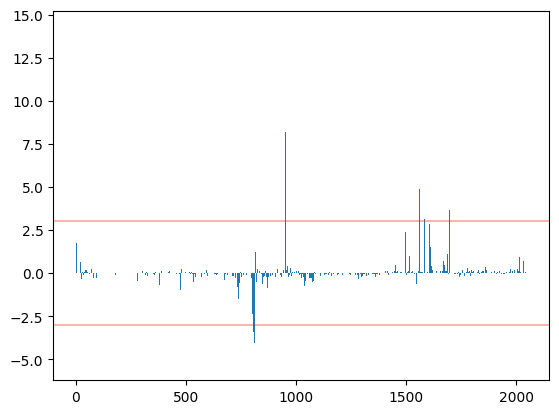

In [275]:
def get_diff_indexes(marker='G3BP1', threshold=2.5):
    plt.bar(np.arange(len(diff.loc[marker,:])), diff.loc[marker,:])
    plt.axhline(threshold, alpha=0.3, color='red')
    plt.axhline(-threshold,  alpha=0.3, color='red')

    diff_indexes_up = diff.loc[marker,diff.loc[marker,:] >= threshold].index
    diff_indexes_down = diff.loc[marker,diff.loc[marker,:] <= -threshold].index
    return diff_indexes_up, diff_indexes_down

diff_indexes_up, diff_indexes_down = get_diff_indexes(threshold=3)

In [372]:
def replace_diff_indexes_with(indx=0, codeword=None, swap=False, is_baseline=True, only_up=False, only_down=False):
    # is_baseline - if the image is stress set it to True, False otherwise (untreated)
    # swap - Swap upregualted codeword with dowregulated ones
    # index - Set to all up/downregulated codewords the i codeword from the codebook
    # codeword - Set this codeword to all up/downregulated codewords
    vq_idx = 1
    emb1_copy = emb1.clone()
    
    embind1 = model.model.infer_embeddings(img, f'vqind{vq_idx}')
    embind1 = torch.from_numpy(embind1)
    print(embind1.shape)
    
    codebook = model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()

    if not swap:
        placeholder_word = torch.from_numpy(codebook[indx]) if codeword is None else codeword
        placeholder_word.shape

    indexes_to_replace_up = np.isin(embind1[0][0].detach().cpu().numpy(), diff_indexes_up)
    indexes_to_replace_down = np.isin(embind1[0][0].detach().cpu().numpy(), diff_indexes_down)
    
    if is_baseline:
        _tmp = indexes_to_replace_up
        indexes_to_replace_up = indexes_to_replace_down
        indexes_to_replace_down = _tmp
    
    if not swap:
        placeholder_word_up = placeholder_word
        placeholder_word_down = -placeholder_word
    
    # if swap:
    #     placeholder_word_up = codebook[diff_indexes_down[0]]
        # placeholder_word_down = codebook[diff_indexes_up[0]]
    
    print(np.sum(indexes_to_replace_up), np.sum(indexes_to_replace_down))

    for i in range(emb1_copy.shape[2]):
        for j in range(emb1_copy.shape[3]):
            if indexes_to_replace_up[i,j] and not only_down:
                print(f"Here, ({i}, {j})")
                if swap:
                    placeholder_word_up = codebook[diff_indexes_down[np.random.choice(len(diff_indexes_down))]]
                    placeholder_word_up = torch.from_numpy(placeholder_word_up)
                    # print(placeholder_word_up)
                assert torch.any(emb1_copy[:,:, i,j] != placeholder_word_up), "The same"
                emb1_copy[:,:, i,j] = placeholder_word_up
            elif indexes_to_replace_down[i,j] and not only_up:
                if not swap:
                    print(f"Here Down, ({i}, {j}), {placeholder_word_down}")
                    emb1_copy[:,:, i,j] = placeholder_word_down
            # else:
            #     if not swap:
            #         emb1_copy[:,:, i,j] = torch.zeros((64,))


    # for i in range(indexes_to_replace_up.shape[0]):
    #     for j in range(indexes_to_replace_up.shape[1]):
    #         if not indexes_to_replace_up[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = placeholder_word
            
    # for i in range(indexes_to_replace_down.shape[0]):
    #     for j in range(indexes_to_replace_down.shape[1]):
    #         if not indexes_to_replace_down[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = -placeholder_word
    
    return emb1_copy

In [1]:
def highlight_codevecs_separatly():
    # is_baseline - if the image is stress set it to True, False otherwise (untreated)
    # swap - Swap upregualted codeword with dowregulated ones
    # index - Set to all up/downregulated codewords the i codeword from the codebook
    # codeword - Set this codeword to all up/downregulated codewords
    vq_idx = 1
    
    embind1 = model.model.infer_embeddings(img, f'vqind{vq_idx}')
    embind1 = torch.from_numpy(embind1)
    print(embind1.shape)
    
    # codebook = model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()

    all_indexes = np.unique(embind1[0][0].detach().cpu().numpy())
    print(len(all_indexes))
    
    
    for index in all_indexes:
        index_to_highlight = torch.argwhere(embind1[0][0] == index)
        for i in index_to_highlight:
            emb1_copy = torch.zeros_like(emb1)
            emb1_copy[:,:, i[0],i[1]] = torch.ones((64,))*10000
            r = reconstruct_image(emb1_copy, emb2)
            plt.imshow(img_original[0,0,...], cmap='gray')
            plt.imshow(r[0,0,...], alpha=0.3, cmap='seismic')
            plt.show()
            # else:
            #     if not swap:
            #         emb1_copy[:,:, i,j] = torch.zeros((64,))


    # for i in range(indexes_to_replace_up.shape[0]):
    #     for j in range(indexes_to_replace_up.shape[1]):
    #         if not indexes_to_replace_up[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = placeholder_word
            
    # for i in range(indexes_to_replace_down.shape[0]):
    #     for j in range(indexes_to_replace_down.shape[1]):
    #         if not indexes_to_replace_down[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = -placeholder_word
    
    # return emb1_copy

2023-10-05 17:25:31 INFO [infer_embeddings] output_layer = vqind1


2023-10-05 17:25:32 INFO [cyto vq] encoding_onehot shape: (torch.Size([625, 2048])) torch.Size([1, 25, 25, 64])
2023-10-05 17:25:32 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 64])) (torch.Size([1, 64, 25, 25]))
2023-10-05 17:25:32 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 2048])) encoding_onehot: torch.Size([1, 2048, 25, 25])
2023-10-05 17:25:32 INFO [cyto vq] unsplit (torch.Size([625])) encoding_indices: torch.Size([1, 1, 25, 25])


torch.Size([1, 1, 25, 25])
320
torch.Size([1, 2, 100, 100])


AttributeError: 'AxesImage' object has no property 'colors'

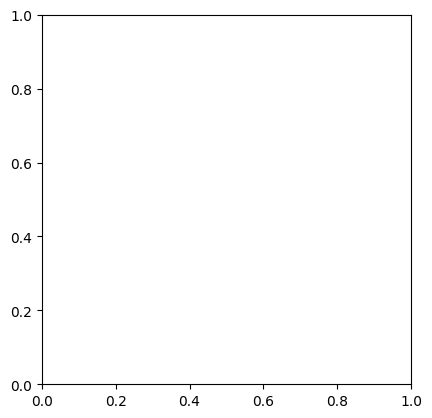

In [382]:
highlight_codevecs_separatly()

In [375]:
emb1_altered = replace_diff_indexes_with(swap=False, is_baseline=False, codeword=torch.ones((64,))*1000000, only_down=True)
emb1_altered.shape

2023-10-05 16:09:36 INFO [infer_embeddings] output_layer = vqind1
2023-10-05 16:09:37 INFO [cyto vq] encoding_onehot shape: (torch.Size([625, 2048])) torch.Size([1, 25, 25, 64])
2023-10-05 16:09:37 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 64])) (torch.Size([1, 64, 25, 25]))
2023-10-05 16:09:37 INFO [cyto vq] unsplit (torch.Size([1, 25, 25, 2048])) encoding_onehot: torch.Size([1, 2048, 25, 25])
2023-10-05 16:09:37 INFO [cyto vq] unsplit (torch.Size([625])) encoding_indices: torch.Size([1, 1, 25, 25])


torch.Size([1, 1, 25, 25])
55 11
Here Down, (2, 1), tensor([-1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000.])
Here Down, (3, 1), tensor([-1000000., -1000000., -1000000., -1000000., -1000000., -1000000.,
        -1000000., -1000000., -1000000., -1000000., -1000000.,

torch.Size([1, 64, 25, 25])

In [377]:
def reconstruct_image(emb1, emb2):
    emb_both = torch.cat([emb2, emb1], 1)
    model.model.model.eval()
    with torch.no_grad():
        img_reconstructed = model.model.model.decoders[0](emb_both)
    print(img_reconstructed.shape)
    # plt.imshow(img_reconstructed[0,0,...])
    # plt.show()
    return img_reconstructed

In [331]:
# model.model.model.eval()
# with torch.no_grad():
#     v = model.model.model.decoders[0](torch.ones((1,640, 25, 25))*1000000)
# print(torch.min(v[0,0]))
# # plt.imshow(v[0,0])

tensor(97144.7812)


In [356]:
import matplotlib


def show_reco_image(img, altered):
    print("Original")
    plt.imshow(img_original[0,0,...], cmap='seismic')
    plt.show()
    
    assert torch.any(img[0,0,...] != altered[0,0,...]), "The same"
    print("Reconstructed")
    plt.imshow(img[0,0,...], cmap='seismic')#, vmin=0, vmax=255)
    plt.show()
    # print("Modified Reconstructed")
    # plt.imshow(altered[0,0,...], alpha=1, cmap='seismic')#, cmap='seismic')
    # plt.show()
    
    c = torch.zeros(altered[0,0,...].shape)
    ci = torch.argwhere(img[0,0,...] != altered[0,0,...])
    for k in ci:
        c[k[0], k[1]] = 100000
    
    # ci_up = torch.argwhere(altered[0,0,...] > 10000)#torch.argwhere(torch.argwhere(img[0,0,...] != altered[0,0,...]))#
    # for k in ci_up:
    #     c[k[0], k[1]] = 100000
    # ci_down = torch.argwhere(altered[0,0,...] < -10000)#torch.argwhere(img[0,0,...] != altered[0,0,...])
    # for k in ci_down:
    #     c[k[0], k[1]] = -100000
    
    # print("Modifications")
    cmap = matplotlib.colors.ListedColormap(['white', 'yellow'])
    # plt.imshow(c, cmap=cmap)
    # plt.colorbar()
    # plt.show()
    print("Diff")
    plt.imshow(c, cmap=cmap)
    plt.show()
    print("Diff Overlay")
    plt.imshow(img[0,0,...], cmap='seismic')#, cmap='seismic')
    plt.imshow(c, alpha=0.3, cmap=cmap)
    plt.colorbar()
    plt.show()

torch.Size([1, 2, 100, 100])
torch.Size([1, 2, 100, 100])
Original


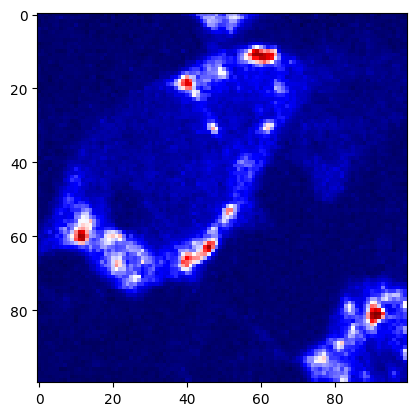

Reconstructed


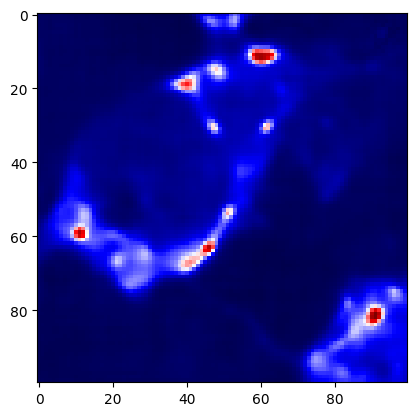

Diff


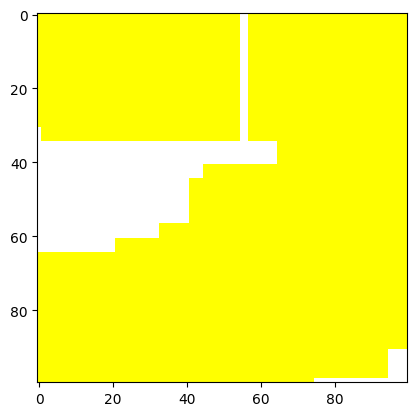

Diff Overlay


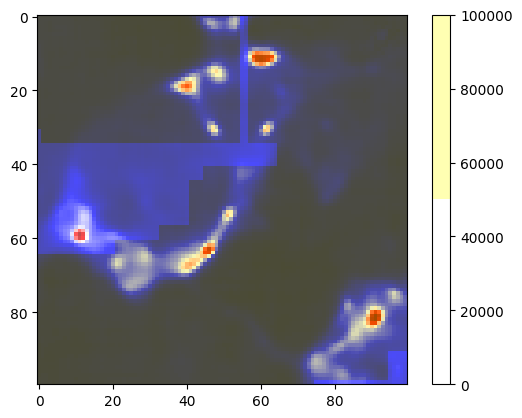

In [374]:
reco = reconstruct_image(emb1, emb2)
reco_altered = reconstruct_image(emb1_altered, emb2)
show_reco_image(reco, reco_altered)

torch.Size([1, 2, 100, 100])
torch.Size([1, 2, 100, 100])
Original


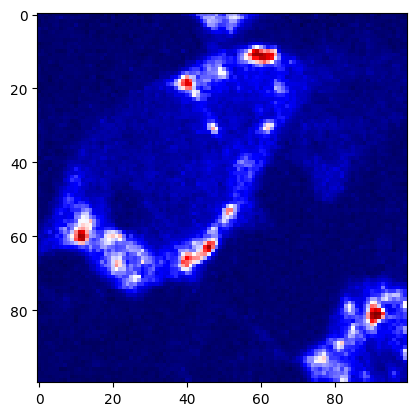

Reconstructed


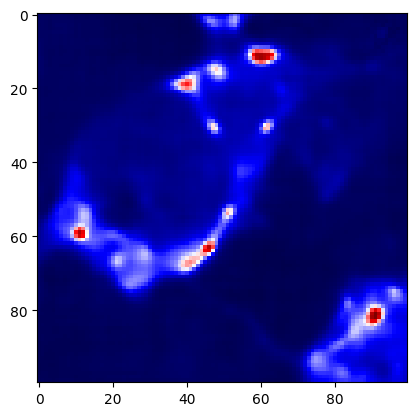

Diff


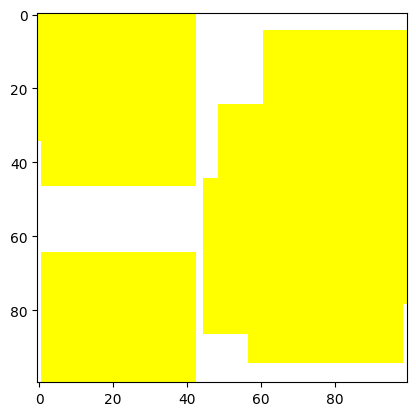

Diff Overlay


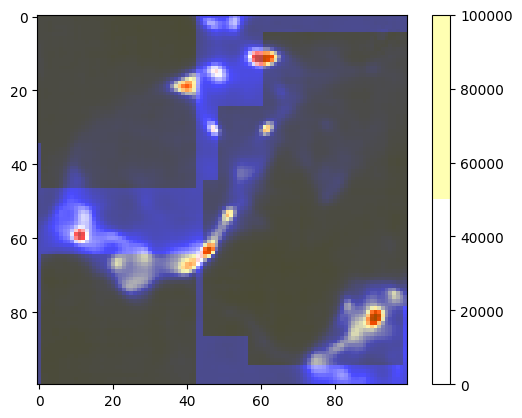

In [376]:
reco = reconstruct_image(emb1, emb2)
reco_altered = reconstruct_image(emb1_altered, emb2)
show_reco_image(reco, reco_altered)

torch.Size([1, 2, 100, 100])
torch.Size([1, 2, 100, 100])
Original


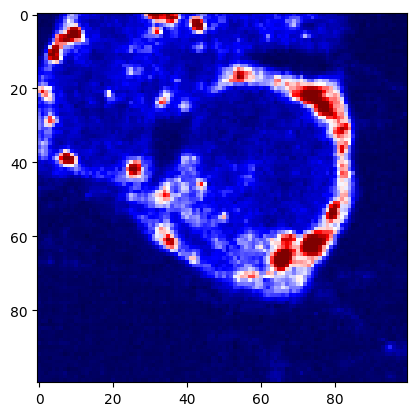

Reconstructed


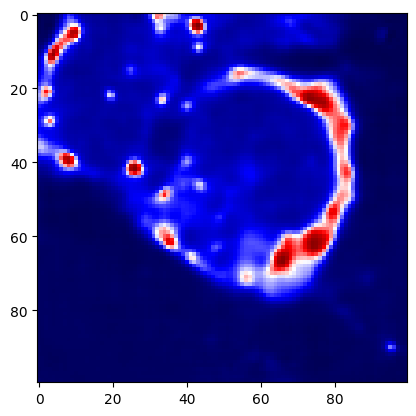

Diff


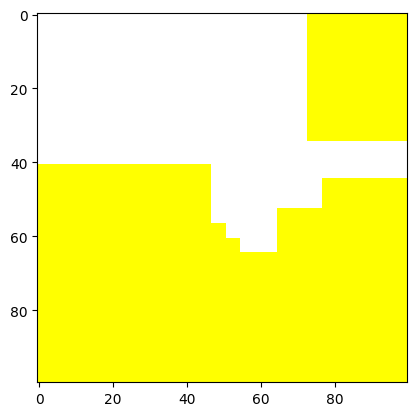

Diff Overlay


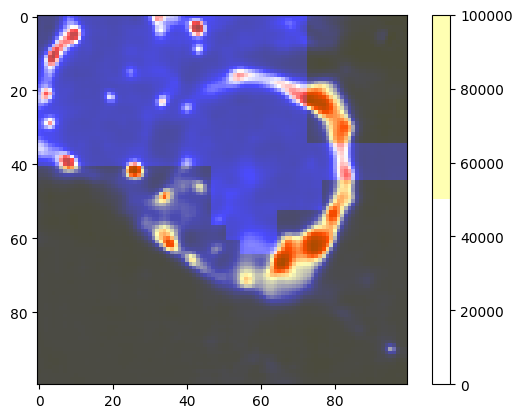

In [363]:
reco = reconstruct_image(emb1, emb2)
reco_altered = reconstruct_image(emb1_altered, emb2)
show_reco_image(reco, reco_altered)

torch.Size([1, 2, 100, 100])
torch.Size([1, 2, 100, 100])
Original


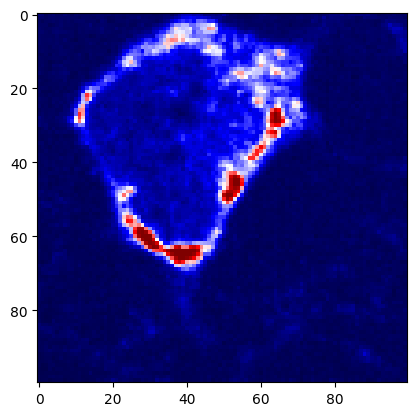

Reconstructed


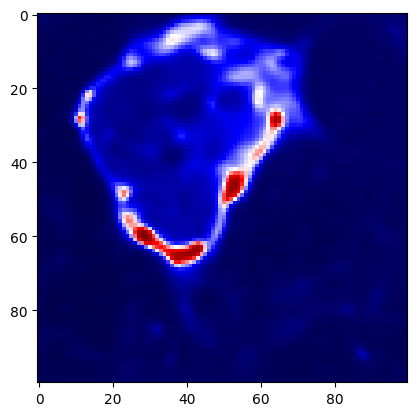

Diff


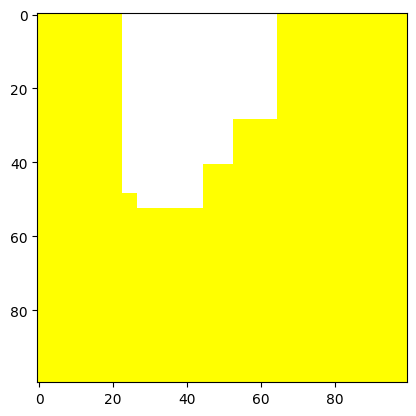

Diff Overlay


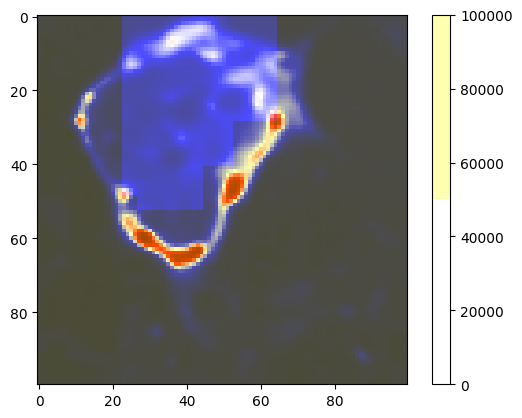

In [360]:
reco = reconstruct_image(emb1, emb2)
reco_altered = reconstruct_image(emb1_altered, emb2)
show_reco_image(reco, reco_altered)